# Modeing Rating and Reviews data

**PACKAGES**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime

import os
import pickle
import time
from tqdm import tqdm

from fuzzywuzzy import fuzz
import textdistance

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

C:\Users\asaid\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**CODE PARAMETERS**

In [105]:
# PANDAS DISPLAY PARAMETERS
# Setting the number of maximum columns and rows to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 1)

In [3]:
# PATHS FOR RATINGS AND REVIEWS
input_reviews_dir_path = r'../data/raw_data/Rating and Reviews/'
output_reviews_dir_path = r'../data/clean_data/'

# PATHS FOR PRODUCT CATALOGUE
input_product_dir_path = r'../data/raw_data/Product Catalogue/'
output_product_dir_path = r'../data/clean_data/'

# PATHS FOR DEMAND
input_demand_dir_path = r'../data/raw_data/Demand Data/'
output_demand_dir_path = r'../data/clean_data/'

# PATHS FOR BRAND MAPPINGS
input_brands_dir_path = r'../data/clean_data/'
output_brands_dir_path = r'../data/clean_data/'

# PATHS FOR SUBCATEGORIES MAPPINGS
input_sub_categories_dir_path = r'../data/clean_data/'
output_sub_categories_dir_path = r'../data/clean_data/'

In [4]:
code_start = time.time()

## Data Wrangling

**Quick explanation:**

The data is broken into *Product Catalogues* and *Ratings and Reviews*. *Product Catalogues* contain data about the products. Ratings and Reviews contain data about reviews (EZ). Each of the two are broken into *skincare* and *cosmetics*. The granularity of the data is *Brand* and *Sub Category* also called *ELC Solution Type* (lipstick, gloss etc.). The *Rating and Reviews* data contains the *ELC Solution Type* column but does not contain the *Brand* column. The *Brand* can be retrived from the *Product Catalogue*.

Therefore, we need to join the *Rating and Reviews* data with the *Product Catalogue* then join that to the demand data and finally apply our models.

NB: The *Product Catalogues* and *Ratings and Reviews* files get uploaded to a shared folder once in a while. The *demand* data is downloaded from a certain server.

### Wrangling Demand Data

Before this code, I manually deleted the first row of the xlsx file and saved it as a .csv file. A lot of formating needs to be done to transform the data into a Pandas friendly DataFrame.

#### Read data

In [34]:
# Read data
demand = pd.read_csv(os.path.join(input_demand_dir_path,'full_demand.csv'), encoding="ISO-8859-1")

#### Data description

The demand data is a bit messy, all the number are in text format. The brands are represented using abbreviations but we have a mapping between brands and there abbreviation. 

In [6]:
print("DATA SAMPLE:")
display(demand.sample(3))
print("DATA DESCRIPTION:")
display(demand.describe(include='all'))

DATA SAMPLE:


Brand ItemID 4                 Item Description     Affiliate  \
3871     CL     K399  EVEN BETTER BRIGHTR ESSENCE LTN  UK AFFILIATE   
38577    LL     J1C9                       V46 EDP RM            US   
18753    AV     AG51                      CALMNESS'14            US   

      Major Category              Category          Sub Category  \
3871        Skincare  Watery /Treatment/Es  All Watery /Treatmen   
38577      Fragrance                Juices                   EDP   
18753       Skincare  Cross Application Se  All Cross Applicatio   

                Application 7/1/2016 8/1/2016 9/1/2016 10/1/2016 11/1/2016  \
3871                   Face        -        -        -         -         -   
38577  All Fragrance Juices        -        -        -         -         -   
18753  CROSS APPLICATION SE        -        -        -       432         -   

      12/1/2016 1/1/2017 2/1/2017 3/1/2017 4/1/2017 5/1/2017 6/1/2017  \
3871          -        -        -        -        -        -        -   
38577         -        -        -        -        -        -        -   
18753         -        -        -        -        -    3,888        -   

      7/1/2017 8/1/2017 9/1/2017 10/1/2017 11/1/2017 12/1/2017 1/1/2018  \
3871         -        -        -         -         -         -        -   
38577        -        -        -         -         -         -        -   
18753        -        -        -         -         -         -        -   

      2/1/2018 3/1/2018 4/1/2018 5/1/2018 6/1/2018 7/1/2018 8/1/2018 9/1/2018  \
3871         -        -        -        -        -        -        -        -   
38577        -        -        -        -        -        -        -        -   
18753        -        -        -        -        -        -        -        -   

      10/1/2018 11/1/2018 12/1/2018 1/1/2019 2/1/2019 3/1/2019 4/1/2019  \
3871          -         -         -       46        -        -        -   
38577         -         -         -        -        -        3        6   
18753         -         -         -        -        -        -        -   

      5/1/2019 6/1/2019 7/1/2019 8/1/2019 9/1/2019 10/1/2019 11/1/2019  \
3871         -       21        -        -        -         3         3   
38577       18       12       12        9       21        23         3   
18753        -        -        -        -        -         -         -   

      12/1/2019 1/1/2020 2/1/2020 3/1/2020 4/1/2020 5/1/2020 6/1/2020  
3871          6        6        4        -        3        2        2  
38577         -        -        -        -        -       18       12  
18753         -        -        -        -        -        -        -

DATA DESCRIPTION:


Brand ItemID 4 Item Description Affiliate Major Category Category  \
count   42426    42426            42426     42426          42426    42426   
unique     21    17865            16759         4              5       92   
top        EL     0KWP         LIPSTICK        US         Makeup   Juices   
freq     5740       22              165     15769          12934     7503   

       Sub Category Application 7/1/2016 8/1/2016 9/1/2016 10/1/2016  \
count         42426       42426    42426    42426    42426     42426   
unique          204          23     3367     3849     4248      4011   
top             EDP        Face        -        -        -         -   
freq           4796       11314    30724    30012    29416     29467   

       11/1/2016 12/1/2016 1/1/2017 2/1/2017 3/1/2017 4/1/2017 5/1/2017  \
count      42426     42426    42426    42426    42426    42426    42426   
unique      4217      3987     3418     3711     3926     3507     3695   
top            -         -        -        -        -        -        -   
freq       29349     29331    29947    30009    29709    29936    29621   

       6/1/2017 7/1/2017 8/1/2017 9/1/2017 10/1/2017 11/1/2017 12/1/2017  \
count     42426    42426    42426    42426     42426     42426     42426   
unique     4013     3165     3776     3882      3853      3913      3705   
top           -        -        -        -         -         -         -   
freq      29259    30692    30116    29708     29609     29508     29950   

       1/1/2018 2/1/2018 3/1/2018 4/1/2018 5/1/2018 6/1/2018 7/1/2018  \
count     42426    42426    42426    42426    42426    42426    42426   
unique     3153     3418     3716     3337     3332     3696     2886   
top           -        -        -        -        -        -        -   
freq      30578    30697    30140    30617    30586    30420    31439   

       8/1/2018 9/1/2018 10/1/2018 11/1/2018 12/1/2018 1/1/2019 2/1/2019  \
count     42426    42426     42426     42426     42426    42426    42426   
unique     3354     3821      3644      3873      3437     3194     3295   
top           -        -         -         -         -        -        -   
freq      30626    30120     30364     30080     30558    30839    31026   

       3/1/2019 4/1/2019 5/1/2019 6/1/2019 7/1/2019 8/1/2019 9/1/2019  \
count     42426    42426    42426    42426    42426    42426    42426   
unique     3547     3328     3396     3655     3092     3388     3676   
top           -        -        -        -        -        -        -   
freq      29904    30285    29997    29633    30582    30125    29421   

       10/1/2019 11/1/2019 12/1/2019 1/1/2020 2/1/2020 3/1/2020 4/1/2020  \
count      42426     42426     42426    42426    42426    42426    42426   
unique      3867      3720      3412     3173     3208     2976     2317   
top            -         -         -        -        -        -        -   
freq       29054     29662     29929    30357    30659    30712    31814   

       5/1/2020 6/1/2020  
count     42426    42426  
unique     2063     2328  
top           -        -  
freq      31725    31073

#### Data wrangling

In [95]:
# Read data
demand = pd.read_csv(os.path.join(input_demand_dir_path,'full_demand.csv'), encoding="ISO-8859-1")

In [96]:
# Pandas friendly column names
demand.columns = [col.lower().strip().replace(' ','_') for col in demand.columns]

In [97]:
# We extract the columns that contain demand data. They have the format (dd/mm/yyy)
# TODO: use regex. Bleh
dates_columns = demand.columns[demand.columns.str.contains('/')].tolist()

In [98]:
# In xlsx 0 is marked as '-' which cause the demand columns to be read as of type object (str).
# We need to replace the '-' by 0 and transform the type to int so that we can aggregate using sum().
temp = demand[dates_columns]
temp[temp == '-'] = 0
demand[dates_columns] = temp
del temp

C:\Users\asaid\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\asaid\Anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [99]:
demand[demand=='-'] = np.nan

C:\Users\asaid\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [100]:
demand = demand.dropna()

In [108]:
groupbycols = [
    'brand',
    'itemid_9',
    'item_description',
    'affiliate',
    'major_category_id',
    'major_category',
    'application_id',
    'application',
    'category_id',
    'category',
    'sub_category_id',
    'sub_category',
    'product_line_id',
    'product_line',
    'sub_product_line_id',
    'sub_product_line',
    'major_inventory',
    'inventory']

In [110]:
# We aggregate the data
# demand = demand.groupby(groupbycols)[dates_columns].sum()
demand = demand.set_index(groupbycols)

# Finally we use stack to create a columns date, and have a row for each seperate month
demand.columns.name = 'date'
demand = demand.stack().to_frame('demand').reset_index()
demand['date'] = pd.to_datetime(demand['date'], errors='coerce').values.astype('datetime64[M]')

In [111]:
demand.sample(10)

brand    itemid_9              item_description affiliate  \
3034274    BK  H1AP011000        FL BRING ON THE BRONZE        US   
1611579    AV  A1TF01J000          SHAMPURE CONDITIONER        US   
2511273    JM  L4W9010000   BODY & HAND WASH GRAPEFRUIT        US   
2216717    BB  EGNH900000                 BOBBI TO GO 5        US   
2862679    DA  D7J2010000          THE REVITALIZING OIL        US   
3002825    KL  N3E6010000          LOVE DONT BE SHY EDP        US   
2157757    BB  E2LE131000    SKIN FOUNDATION SPF 15 PA+        US   
2159542    BB  ENXK901000             BRONZE SB W BRUSH        US   
204123     CL  KA3P901000         CL F18 NA GWP GIFT 6A        US   
1626852    SX  C023061000  CAMERA READY BB CREAM SPF 35        US   

         major_category_id major_category application_id  \
3034274                510         Makeup             40   
1611579                540       Haircare             37   
2511273                530      Fragrance             97   
2216717                510         Makeup             15   
2862679                520       Skincare             25   
3002825                530      Fragrance             92   
2157757                510         Makeup             25   
2159542                510         Makeup             40   
204123                 520       Skincare             95   
1626852                510         Makeup             25   

                  application category_id              category  \
3034274            Face Color          2B               Bronzer   
1611579             Hair Care          68           Conditioner   
2511273  Fragranced Body & Ha          86       Fragranced Bath   
2216717                  Eyes          96   Cross Category Sets   
2862679                  Face          3A              Face Oil   
3002825  All Fragrance Juices          61                Juices   
2157757                  Face          28            Foundation   
2159542            Face Color          2B               Bronzer   
204123   CROSS MAJOR CATEGORY          92  Cross Major Category   
1626852                  Face          28            Foundation   

        sub_category_id          sub_category product_line_id  \
3034274              20           All Bronzer              66   
1611579              92             All Other             390   
2511273              58  Cleansers(Incl Soap)             240   
2216717              6A  All Cross Category S              53   
2862679              S1         All Face Oils             265   
3002825              52                   EDP             525   
2157757              26     Liquid Foundation             315   
2159542              20           All Bronzer              53   
204123               6B  All Cross Major Cate              15   
1626852              B1      Cream Foundation             183   

                 product_line sub_product_line_id  \
3034274                 Flirt                 861   
1611579              Shampure                  72   
2511273           CORE SCENTS                 487   
2216717           Bobbi Brown                 775   
2862679  Essential Oil Elixir                 928   
3002825                  Love                 K77   
2157757                  Skin                 H19   
2159542           Bobbi Brown                 775   
204123               Clinique                 200   
1626852          Camera Ready                 A53   

                    sub_product_line major_inventory          inventory  \
3034274              FLIRT-all other        Saleable  Standard Saleable   
1611579                 All Shampure        Saleable  Standard Saleable   
2511273                   Grapefruit        Saleable  Standard Saleable   
2216717                  Bobbi Brown     Promotional              Gifts   
2862679         Essential Oil Elixir        Saleable  Standard Saleable   
3002825                         Love        Saleable  Standard Saleable   
2157757                 

In [112]:
demand.to_csv(os.path.join(output_demand_dir_path,'demand.csv'), index=False)

In [113]:
# If the wrangled files already exist
demand = pd.read_csv(os.path.join(output_demand_dir_path,'demand.csv'))
demand.sample(10)

C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6,8,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


brand    itemid_9                 item_description affiliate  \
2878756    DA  D829Y60000          INTRAL XMAS SET FY17-WN        US   
428937     MC  S47PC00000                         LIPGLASS        US   
2044980    AR  5FM9901000                      CM GOLD BAG        US   
3079771    FM  H497010000               PORTRAIT OF A LADY        US   
354905     CL  ZR7Y010000                        DDMC MINI        US   
2189714    BB  EELP010000  NUDE FINISH ILLUMINATING POWDER        US   
2470332    BU  B373Y91000           READY SET FETE HIO DUO        US   
2314553    BB  EHRA010000           BRONZER / FACE BLENDER        US   
2639232    CM  5R0P410000            REGENERATING SERUM-WN        US   
858434     MC  SKEC170000     POWERGLASS PLUMPING GLOSS-WN        US   

         major_category_id major_category application_id  \
2878756                520       Skincare             94   
428937                 510         Makeup             10   
2044980                590          Other             99   
3079771                530      Fragrance             92   
354905                 520       Skincare             25   
2189714                510         Makeup             25   
2470332                540       Haircare             36   
2314553                510         Makeup             90   
2639232                520       Skincare             25   
858434                 510         Makeup             10   

                  application category_id              category  \
2878756  CROSS APPLICATION SE          95  Cross Application Se   
428937                   Lips          12             Lip Gloss   
2044980  All Other Applicatio          90           Accessories   
3079771  All Fragrance Juices          61                Juices   
354905                   Face          31          Moisturizers   
2189714                  Face          26           Face Powder   
2470332          Hair Styling          96   Cross Category Sets   
2314553  All Other Makeup App          2G               Brushes   
2639232                  Face          41     Serums & Essences   
858434                   Lips          12             Lip Gloss   

        sub_category_id          sub_category  product_line_id  \
2878756              64  All Cross Applicatio              271   
428937               18         All Lip Gloss              215   
2044980              35          Bags / Totes              431   
3079771              52                   EDP              551   
354905               80          Moisturizers               16   
2189714              A2   Pressed Face Powder               53   
2470332              6A  All Cross Category S              132   
2314553              MM          Face Brushes               53   
2639232              ZK  All Other Serums & E               56   
858434               18         All Lip Gloss               57   

               product_line sub_product_line_id             sub_product_line  \
2878756  Intral - Sensitive                 907      Intral - Sensitive Skin   
428937          Traditional                 E68     All Traditional Products   
2044980       Cashmere Mist                 406           Cashmere Mist Core   
3079771    Parfums-Editions                 M23           PORTRAIT OF A LADY   
354905               3 Step                 606                         DDMC   
2189714         Bobbi Brown                 775                  Bobbi Brown   
2470332   Bumble and bumble                 C24  Hairdresser's Invisible Oil   
2314553         Bobbi Brown                 775                  Bobbi Brown   
2639232              La Mer                 575                   All La Mer   
858434                  MAC                 700                          MAC   

        major_inventory          inventory        date demand  
2878756        Saleable  Standard Saleable  2019-11-01      0  
428937         Saleable  Standard Saleable  2016-04-01      0  
2044980     Prom

### Wrangling Rating and Reviews

#### Read and concatenate data

First we need to read all the files and concatenate them.

In [11]:
# List of available files
os.listdir(input_reviews_dir_path)

['cosmetics_reviews_20191130_final.csv',
 'cosmetics_reviews_20200101-20200131.csv',
 'cosmetics_reviews_20200229.csv',
 'cosmetics_reviews_20200331.csv',
 'old_files',
 'pwds',
 'skincare_reviews_20150201-20200131.csv',
 'skincare_reviews_20200229.csv',
 'skincare_reviews_20200331.csv',
 'template']

In [12]:
start = time.time()
reviews_skincare = pd.DataFrame()
reviews_cosmetics = pd.DataFrame()
for file in os.listdir(input_reviews_dir_path):
    if '.csv' in file.lower():
        if 'skincare' in file.lower():
            interm = time.time()
            print('\nReading', file)
            temp = pd.read_csv(os.path.join(input_reviews_dir_path,file), low_memory=False)
            temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
            temp.columns = [colname.lower().replace(' ','_') for colname in temp.columns]
            print('Concatenating', file)
            reviews_skincare=pd.concat([reviews_skincare, temp], ignore_index=True)
            print('Time for this dataset: %.0f seconds' % (time.time()-interm))
            print('Total time: %.0f seconds' % (time.time()-start))
        elif 'cosmetics' in file.lower():
            interm = time.time()
            print('\nReading', file)
            temp = pd.read_csv(os.path.join(input_reviews_dir_path,file), low_memory=False)
            temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
            temp.columns = [colname.lower().replace(' ','_') for colname in temp.columns]
            print('Concatenating', file)
            reviews_cosmetics=pd.concat([reviews_cosmetics, temp], ignore_index=True)
            print('Time for this dataset: %.0f seconds' % (time.time()-interm))
            print('Total time: %.0f seconds' % (time.time()-start))
del temp


Reading cosmetics_reviews_20191130_final.csv
Concatenating cosmetics_reviews_20191130_final.csv
Time for this dataset: 216 seconds
Total time: 216 seconds

Reading cosmetics_reviews_20200101-20200131.csv
Concatenating cosmetics_reviews_20200101-20200131.csv
Time for this dataset: 59 seconds
Total time: 274 seconds

Reading cosmetics_reviews_20200229.csv
Concatenating cosmetics_reviews_20200229.csv
Time for this dataset: 61 seconds
Total time: 335 seconds

Reading cosmetics_reviews_20200331.csv
Concatenating cosmetics_reviews_20200331.csv
Time for this dataset: 62 seconds
Total time: 397 seconds

Reading skincare_reviews_20150201-20200131.csv
Concatenating skincare_reviews_20150201-20200131.csv
Time for this dataset: 36 seconds
Total time: 433 seconds

Reading skincare_reviews_20200229.csv
Concatenating skincare_reviews_20200229.csv
Time for this dataset: 8 seconds
Total time: 441 seconds

Reading skincare_reviews_20200331.csv
Concatenating skincare_reviews_20200331.csv
Time for this d

In [13]:
reviews_cosmetics = reviews_cosmetics.drop_duplicates()
reviews_skincare = reviews_skincare.drop_duplicates()

In [14]:
reviews_cosmetics.to_csv(os.path.join(output_reviews_dir_path,'reviews_cosmetics.csv'), index=False)
reviews_skincare.to_csv(os.path.join(output_reviews_dir_path,'reviews_skincare.csv'), index=False)

In [156]:
# If concatenated files already exist
reviews_cosmetics = pd.read_csv(os.path.join(output_reviews_dir_path,'reviews_cosmetics.csv'))
reviews_skincare = pd.read_csv(os.path.join(output_reviews_dir_path,'reviews_skincare.csv'))

C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (23,25,28,29,30,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data description

Each review/post has a unique *OnlinePost_ID*. Each *OnlinePost_ID* is broken into different *Statements*. Each statement has a unique *OnlineStatement_ID* which is the concatenation of the *OnlineStatement_ID* and the rank of the statement. A statement is usually a sentence or a comment. The actual text is contained in the *Description* column.

The Reviews data and the Products data must be joined using *Source Product Identifier* and *Channel* as a compounded key.

**COSMETICS**

In [16]:
print("DATA SAMPLE:")
display(reviews_cosmetics.sample(3))
print("DATA DESCRIPTION:")
display(reviews_cosmetics.describe(include='all'))
print("% OF MISSING DATA:")
display((reviews_cosmetics.isna().sum()/len(reviews_cosmetics))*100)

DATA SAMPLE:


onlinepost_id source_product_identifier  \
8053491  OnlinePost_20190724_159633855                   3761879   
3247261  OnlinePost_20191027_185254517        xlsImpprod10791965   
7800823  OnlinePost_20191027_181751107                     87190   

                           onlinestatement_id        date  \
8053491  OnlineStatement_20190724_159633855_4  2017-07-25   
3247261  OnlineStatement_20191027_185254517_8  2018-07-06   
7800823  OnlineStatement_20191027_181751107_7  2018-02-22   

                                            title  \
8053491                           Great Brow Tint   
3247261  Something has changed with this mascara.   
7800823                             Face Love it!   

                                               description geography  \
8053491  I have fair brows and can tint, shape and set ...       USA   
3247261   Then it is just a mess to try and scrape it off.       USA   
7800823  not all Women of color red 'red' as background...       USA   

               channel                product_id  rating sentiment  \
8053491      Nordstrom  Product_20191016_5328568     5.0   Neutral   
3247261           Ulta  Product_20191024_5593267     1.0  Positive   
7800823  Bloomingdales  Product_20191016_5165532     5.0  Negative   

               feature        benefit     ingredient  \
8053491  Not Mentioned  Not Mentioned  Not Mentioned   
3247261  Not Mentioned  Not Mentioned  Not Mentioned   
7800823  Not Mentioned  Not Mentioned  Not Mentioned   

        additional_ingredients_(no_rulebase)   product_form  \
8053491                        Not Mentioned            Gel   
3247261                        Not Mentioned           Wipe   
7800823                        Not Mentioned  Not Mentioned   

            elc_solution_type         finish          looks          other  \
8053491  Eyebrow Liner/Shaper  Not Mentioned  Not Mentioned  Not Mentioned   
3247261               Mascara  Not Mentioned  Not Mentioned  Not Mentioned   
7800823    Tinted Moisturizer  Not Mentioned  Not Mentioned  Not Mentioned   

                trends syndication_source best_for verified_buyer        from  \
8053491  Not Mentioned    Original Source      NaN            NaN         NaN   
3247261  Not Mentioned           CLINIQUE      NaN          False  Dallas, Tx   
7800823  Not Mentioned      LAURA MERCIER      NaN            NaN    Colorado   

        recommended verified_reviewer eye_color hair_color skin_tone gender  \
8053491         NaN               NaN       NaN        NaN       NaN    NaN   
3247261          No             False       NaN        NaN       NaN    NaN   
7800823        True               NaN       NaN        NaN       NaN    NaN   

        i_shop_at_macys.com make-up_style purchase_location cons  pros  \
8053491                 NaN           NaN               NaN  NaN   NaN   
3247261                 NaN           NaN               NaN  NaN   NaN   
7800823                 NaN           NaN               NaN  NaN  None   

        describe_yourself reviewer_skin_type  age  
8053491               NaN                NaN  NaN  
3247261               NaN                NaN  NaN  
7800823               NaN                NaN  NaN

DATA DESCRIPTION:


onlinepost_id source_product_identifier  \
count                        15505326                  15505326   
unique                        3718332                     45195   
top     OnlinePost_20191218_196195647                     19955   
freq                               36                    201329   
mean                              NaN                       NaN   
std                               NaN                       NaN   
min                               NaN                       NaN   
25%                               NaN                       NaN   
50%                               NaN                       NaN   
75%                               NaN                       NaN   
max                               NaN                       NaN   

                                       onlinestatement_id        date  \
count                                            15505326    15505326   
unique                                           15505326        1917   
top     OnlineStatement_20200123_dd41bfc2-99e4-442e-8b...  2016-06-14   
freq                                                    1       37960   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min                                                   NaN         NaN   
25%                                                   NaN         NaN   
50%                                                   NaN         NaN   
75%                                                   NaN         NaN   
max                                                   NaN         NaN   

           title                                        description geography  \
count   15048828                                           15505326  15505326   
unique   1221271                                           10486362         2   
top         None  [This review was collected as part of a promot...       USA   
freq      702320                                             168281  13566615   
mean         NaN                                                NaN       NaN   
std          NaN                                                NaN       NaN   
min          NaN                                                NaN       NaN   
25%          NaN                                                NaN       NaN   
50%          NaN                                                NaN       NaN   
75%          NaN                                                NaN       NaN   
max          NaN                                                NaN       NaN   

         channel                product_id        rating sentiment  \
count   15505326                  15505326  1.550532e+07  15505326   
unique        12                     67659           NaN         3   
top     Birchbox  Product_20191016_5458191           NaN  Positive   
freq     4236243                    201329           NaN  11968623   
mean         NaN                       NaN  4.166802e+00       NaN   
std          NaN                       NaN  1.204049e+00       NaN   
min          NaN                       NaN  1.000000e+00       NaN   
25%          NaN                       NaN  4.000000e+00       NaN   
50%          NaN                       NaN  5.000000e+00       NaN   
75%          NaN                       NaN  5.000000e+00       NaN   
max          NaN                       NaN  5.000000e+00       NaN   

              feature        benefit     ingredient  \
count        15505326       15505326       15505326   
unique            983           9565            101   
top     Not Mentioned  Not Mentioned  Not Mentioned   
freq         14628481       12883031       15491767   
mean              NaN            NaN            NaN   
std               NaN            NaN            NaN   
min               NaN            NaN            NaN   
25%               NaN            NaN            NaN   
50%               NaN            

% OF MISSING DATA:


onlinepost_id                            0.000000
source_product_identifier                0.000000
onlinestatement_id                       0.000000
date                                     0.000000
title                                    2.944137
description                              0.000000
geography                                0.000000
channel                                  0.000000
product_id                               0.000000
rating                                   0.000052
sentiment                                0.000000
feature                                  0.000000
benefit                                  0.000000
ingredient                               0.000000
additional_ingredients_(no_rulebase)     0.000000
product_form                             0.000000
elc_solution_type                        0.000000
finish                                   0.000000
looks                                    0.000000
other                                    0.000000


**REVIEWS**

In [17]:
print("DATA SAMPLE:")
display(reviews_skincare.sample(3))
print("DATA DESCRIPTION:")
display(reviews_skincare.describe(include='all'))
print("% OF MISSING DATA:")
display((reviews_skincare.isna().sum()/len(reviews_skincare))*100)

DATA SAMPLE:


onlinepost_id  \
2274936                      OnlinePost_20191120_140604164   
3458149  OnlinePost_20200219_898d2f27-5f0b-45dd-87f8-71...   
2009748                      OnlinePost_20191120_139924664   

        source_product_identifier  \
2274936                B00AFX1TZ2   
3458149                B00IH0ATYC   
2009748                B075VX4QVM   

                                        onlinestatement_id        date  \
2274936               OnlineStatement_20191120_140604164_3  2017-07-11   
3458149  OnlineStatement_20200219_898d2f27-5f0b-45dd-87...  2020-01-26   
2009748               OnlineStatement_20191120_139924664_3  2019-08-17   

                                           title  \
2274936  My wife says it's OK. Not much of a ...   
3458149                       Scent is awesome!!   
2009748                 Love all their products!   

                                               description geography  \
2274936  Not much of a difference to her original lip c...       USA   
3458149                                 Love this product!       USA   
2009748  I discovered their mascara which is perfect an...       USA   

            channel                 product_id  rating sentiment  \
2274936  Amazon USA  Product_20191016_14017897     3.0  Negative   
3458149  Amazon USA  Product_20200109_15219364     5.0  Positive   
2009748  Amazon USA  Product_20191016_13395955     5.0  Positive   

               feature        benefit     ingredient  \
2274936  Not Mentioned  Not Mentioned  Not Mentioned   
3458149  Not Mentioned  Not Mentioned  Not Mentioned   
2009748  Not Mentioned  Not Mentioned  Not Mentioned   

        additional_ingredients_(no_rulebase) product_form  \
2274936                        Not Mentioned  Balm;Butter   
3458149                        Not Mentioned       Butter   
2009748                        Not Mentioned       Liquid   

                elc_solution_type skin_condition      packaging  \
2274936  Unspecified Lip Skincare  Not Mentioned  Not Mentioned   
3458149                Exfoliator  Not Mentioned  Not Mentioned   
2009748                     Serum  Not Mentioned  Not Mentioned   

             skin_type treatment_area       use_case syndication_source  \
2274936  Not Mentioned           Lips  Not Mentioned    Original Source   
3458149  Not Mentioned  Not Mentioned  Not Mentioned    Original Source   
2009748  Not Mentioned  Not Mentioned  Not Mentioned    Original Source   

        best_for  verified_buyer from recommended  verified_reviewer  \
2274936      NaN             NaN  NaN         NaN                NaN   
3458149      NaN             NaN  NaN         NaN                NaN   
2009748      NaN             NaN  NaN         NaN                NaN   

        eye_color hair_color skin_tone gender  i_shop_at_macys.com  \
2274936       NaN        NaN       NaN    NaN                  NaN   
3458149       NaN        NaN       NaN    NaN                  NaN   
2009748       NaN        NaN       NaN    NaN                  NaN   

        make-up_style purchase_location cons pros describe_yourself  \
2274936           NaN               NaN  NaN  NaN               NaN   
3458149           NaN               NaN  NaN  NaN               NaN   
2009748           NaN               NaN  NaN  NaN               NaN   

        reviewer_skin_type  age  
2274936                NaN  NaN  
3458149                NaN  NaN  
2009748                NaN  NaN

DATA DESCRIPTION:


onlinepost_id source_product_identifier  \
count                         4107027                   4107027   
unique                        1290176                     36465   
top     OnlinePost_20191120_134651626                B07R7RZXJJ   
freq                               39                     20648   
mean                              NaN                       NaN   
std                               NaN                       NaN   
min                               NaN                       NaN   
25%                               NaN                       NaN   
50%                               NaN                       NaN   
75%                               NaN                       NaN   
max                               NaN                       NaN   

                                       onlinestatement_id        date  \
count                                             4107027     4107027   
unique                                            4107027        1886   
top     OnlineStatement_20200301_13d8c7bd-7f77-495b-86...  2020-01-18   
freq                                                    1       11518   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min                                                   NaN         NaN   
25%                                                   NaN         NaN   
50%                                                   NaN         NaN   
75%                                                   NaN         NaN   
max                                                   NaN         NaN   

             title  description geography     channel  \
count      4084200      4107027   4107027     4107027   
unique      519304      3005616         2          12   
top     Five Stars  Five Stars.       USA  Amazon USA   
freq        276495       121635   4009578     3702055   
mean           NaN          NaN       NaN         NaN   
std            NaN          NaN       NaN         NaN   
min            NaN          NaN       NaN         NaN   
25%            NaN          NaN       NaN         NaN   
50%            NaN          NaN       NaN         NaN   
75%            NaN          NaN       NaN         NaN   
max            NaN          NaN       NaN         NaN   

                       product_id        rating sentiment        feature  \
count                     4107027  4.107027e+06   4107027        4107027   
unique                      55624           NaN         3            961   
top     Product_20191016_13953897           NaN  Positive  Not Mentioned   
freq                        19755           NaN   3198497        3737589   
mean                          NaN  4.173652e+00       NaN            NaN   
std                           NaN  1.342025e+00       NaN            NaN   
min                           NaN  1.000000e+00       NaN            NaN   
25%                           NaN  4.000000e+00       NaN            NaN   
50%                           NaN  5.000000e+00       NaN            NaN   
75%                           NaN  5.000000e+00       NaN            NaN   
max                           NaN  5.000000e+00       NaN            NaN   

              benefit     ingredient additional_ingredients_(no_rulebase)  \
count         4107027        4107027                              4107027   
unique           4272            768                                  277   
top     Not Mentioned  Not Mentioned                        Not Mentioned   
freq          3371523        4046160                              4094217   
mean              NaN            NaN                                  NaN   
std               NaN            NaN                                  NaN   
min               NaN            NaN                                  NaN   
25%               NaN            NaN                                  NaN   
50%               NaN            NaN               

% OF MISSING DATA:


onlinepost_id                             0.000000
source_product_identifier                 0.000000
onlinestatement_id                        0.000000
date                                      0.000000
title                                     0.555804
description                               0.000000
geography                                 0.000000
channel                                   0.000000
product_id                                0.000000
rating                                    0.000000
sentiment                                 0.000000
feature                                   0.000000
benefit                                   0.000000
ingredient                                0.000000
additional_ingredients_(no_rulebase)      0.000000
product_form                              0.000000
elc_solution_type                         0.000000
skin_condition                            0.000000
packaging                                 0.000000
skin_type                      

#### Data wrangling

Here are some ideas about the aggregationg of R&R data :
1. Filter on Geography to only keep USA data
2. create date columns (year, month) 
3. change sentiment to numerical data : negative:-1, neurtal:0, positive:1
4. create sentiment one hot encodings 
5. groupby OnlineStatement_ID and aggregate by {sentiment:mean, sentiments_hot_one:average_count)
5. create rating one hot encodings
5. Groupby year, month, Channel, Source Product Identifier
6. Aggregate by {num_sentiment:mean, num_rating:mean, sentiments_hot_one:count, rating_hot_one:count}
7. Count the number of reviews

Then we concatenate cosmetic and skincare, and add a columns *type* to keep track of the source of the data.

**NB**: The columns are not exactly the same between the two types. By concatenting, we will have the union of the features of the two datasets and missing values will be filled with NaNs.

In [157]:
reviews_cosmetics['type'] = 'Cosmetics'
reviews_skincare['type'] = 'Skincare'
reviews = pd.concat([reviews_cosmetics, reviews_skincare], axis=0)


KeyboardInterrupt



In [ ]:
reviews.head(2)

In [20]:
# Filtering geographies on US
reviews = reviews[reviews['geography']=='USA']

In [21]:
# Creating date columns in the right dtype and dropping the day of the month: 2019-02-34 => 2019-02-01
reviews.loc[:,'clean_date'] = pd.to_datetime(reviews['date'], errors='coerce')
if reviews['clean_date'].isna().sum() > 0:
    print('{} rows have been dropped because the date format is wrong.'.format(reviews['clean_date'].isna().sum()))
    display(reviews.loc[reviews['clean_date'].isna(), 'date'])
    reviews = reviews.dropna(subset='date')
reviews['date'] = reviews['clean_date']  
reviews = reviews.drop('clean_date', axis=1)

In [22]:
# Checking for missing data (NA => -1)
if reviews['rating'].isna().sum()>0:
    print('{} rows are missing ratings'.format(reviews['rating'].isna().sum()))
    reviews.loc[:,'rating'] = reviews['rating'].fillna(-1).astype(int)

if reviews['sentiment'].isna().sum()>0:
    print('{} rows are missing sentiments'.format(reviews['sentiment'].isna().sum()))
    reviews.loc[:,'sentiment'] = reviews['sentiment'].fillna(-1).astype(int)

In [23]:
# Transforming rating and sentiment to dummy variables (one-hot encoding)
reviews.loc[:,'sentiment'] = reviews['sentiment'].str.lower()
reviews.loc[:,'rating'] = reviews['rating'].astype(int)
reviews = pd.concat([reviews, pd.get_dummies(data=reviews[['rating','sentiment']], columns=['rating','sentiment'], dtype=int)], axis=1)

In [24]:
# Readding NAs data to ratings
reviews.loc[reviews['rating']==-1,'rating'] = np.nan
reviews.loc[reviews['sentiment']==-1,'sentiment'] = np.nan

In [25]:
# Transforming sentiment to integer data (positive:1; netural:0, negative:-1)
reviews.loc[:,'sentiment'] = reviews['sentiment_positive'] - reviews['sentiment_negative']

In [26]:
# Aggregating RR data by OnlinePost_ID

# Creating a column to count the number of statements by review once aggreagtion happens
reviews['nb_statements'] = reviews['sentiment']

reviews = reviews.groupby(['type',
                             'channel',
                             'source_product_identifier',  
                             'date',
                             'onlinepost_id']).agg({
    'nb_statements':'count',
    'rating':'first',
    'rating_1':'first',
    'rating_2':'first',
    'rating_3':'first',
    'rating_4':'first',
    'rating_5':'first',
    'sentiment_negative':'sum',
    'sentiment_neutral':'sum',
    'sentiment_positive':'sum',
    'sentiment':'mean'
}).reset_index()

# Normalize the one hot sentiment encoding counts (sentiment_negative, sentiment_neutral, sentiment_positive) by the nb_statement.
reviews[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']] = reviews[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']].div(reviews['nb_statements'], axis=0)

In [27]:
reviews.head(4)

type     channel source_product_identifier       date  \
0  Cosmetics  Amazon USA                0001842420 2015-03-04   
1  Cosmetics  Amazon USA                0001842420 2015-04-04   
2  Cosmetics  Amazon USA                0001842420 2015-05-31   
3  Cosmetics  Amazon USA                0001842420 2015-06-03   

                   onlinepost_id  nb_statements  rating  rating_1  rating_2  \
0  OnlinePost_20191121_187403578              2     5.0         0         0   
1  OnlinePost_20191121_189046447              1     5.0         0         0   
2  OnlinePost_20191121_188120318              2     5.0         0         0   
3  OnlinePost_20191121_188840852              1     5.0         0         0   

   rating_3  rating_4  rating_5  sentiment_negative  sentiment_neutral  \
0         0         0         1                 0.0                0.0   
1         0         0         1                 0.0                0.0   
2         0         0         1                 0.0                0.0   
3         0         0         1                 0.0                0.0   

   sentiment_positive  sentiment  
0                 1.0        1.0  
1                 1.0        1.0  
2                 1.0        1.0  
3                 1.0        1.0

In [28]:
# Aggregating RR data by channel + source_product_identifier

# Creating a column to count the number of reviews once aggreagtion happens
reviews['nb_reviews'] = reviews['rating']
reviews['avg_nb_statements'] = reviews['nb_statements']

reviews = reviews.groupby(['type',
                           'channel',
                           'source_product_identifier',
                           'date']).agg({
    'avg_nb_statements':'mean',
    'nb_reviews':'count',
    'rating':'mean',
    'rating_1':'sum',
    'rating_2':'sum',
    'rating_3':'sum',
    'rating_4':'sum',
    'rating_5':'sum',
    'sentiment_negative':'sum',
    'sentiment_neutral':'sum',
    'sentiment_positive':'sum',
    'sentiment':'mean'
}).reset_index()

In [29]:
reviews.head(4)

type     channel source_product_identifier       date  \
0  Cosmetics  Amazon USA                0001842420 2015-03-04   
1  Cosmetics  Amazon USA                0001842420 2015-04-04   
2  Cosmetics  Amazon USA                0001842420 2015-05-31   
3  Cosmetics  Amazon USA                0001842420 2015-06-03   

   avg_nb_statements  nb_reviews  rating  rating_1  rating_2  rating_3  \
0                2.0           1     5.0         0         0         0   
1                1.0           1     5.0         0         0         0   
2                2.0           1     5.0         0         0         0   
3                1.0           1     5.0         0         0         0   

   rating_4  rating_5  sentiment_negative  sentiment_neutral  \
0         0         1                 0.0                0.0   
1         0         1                 0.0                0.0   
2         0         1                 0.0                0.0   
3         0         1                 0.0                0.0   

   sentiment_positive  sentiment  
0                 1.0        1.0  
1                 1.0        1.0  
2                 1.0        1.0  
3                 1.0        1.0

In [30]:
# Saving dataset
reviews.to_csv(os.path.join(output_reviews_dir_path,'reviews_wrangled.csv'), index=False)

In [5]:
# If the wrangled files already exist
reviews = pd.read_csv(os.path.join(output_reviews_dir_path,'reviews_wrangled.csv'))
reviews.sample(10)

C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


type     channel source_product_identifier        date  \
111989   Cosmetics  Amazon USA                B008DF54RS  2019-08-23   
1408018  Cosmetics        Ulta         xlsImpprod5770265  2016-04-21   
668339   Cosmetics   Nordstrom                   3958385  2018-10-10   
730552   Cosmetics   Nordstrom                   5280812  2019-06-22   
1903341   Skincare  Amazon USA                B00PFCTEH8  2017-07-01   
1925461   Skincare  Amazon USA                B00SH46VR2  2020-02-08   
368834   Cosmetics    Birchbox                     23526  2016-11-02   
1563749   Skincare  Amazon USA                B002MSN3QQ  2018-05-01   
2138748   Skincare  Amazon USA                B072BYWFW8  2019-07-18   
2161933   Skincare  Amazon USA                B075QYGQDN  2019-02-18   

         avg_nb_statements  nb_reviews  rating  rating_1  rating_2  rating_3  \
111989                 3.0           1     1.0         1         0         0   
1408018                2.0           1     3.0         0         0         1   
668339                10.0           1     1.0         1         0         0   
730552                 3.0           1     1.0         1         0         0   
1903341                2.0           1     3.0         0         0         1   
1925461                2.0           1     3.0         0         0         1   
368834                 4.0           1     5.0         0         0         0   
1563749                6.0           2     4.5         0         0         0   
2138748                1.5           2     5.0         0         0         0   
2161933                1.0           1     1.0         1         0         0   

         rating_4  rating_5  sentiment_negative  sentiment_neutral  \
111989          0         0                 1.0           0.000000   
1408018         0         0                 0.0           0.000000   
668339          0         0                 0.1           0.400000   
730552          0         0                 0.0           0.333333   
1903341         0         0                 0.0           0.500000   
1925461         0         0                 0.5           0.000000   
368834          0         1                 0.0           0.000000   
1563749         1         1                 0.0           0.285714   
2138748         0         2                 0.0           0.000000   
2161933         0         0                 0.0           0.000000   

         sentiment_positive  sentiment  
111989             0.000000  -1.000000  
1408018            1.000000   1.000000  
668339             0.500000   0.400000  
730552             0.666667   0.666667  
1903341            0.500000   0.500000  
1925461            0.500000   0.000000  
368834             1.000000   1.000000  
1563749            1.714286   0.857143  
2138748            2.000000   1.000000  
2161933            1.000000   1.000000

The Rating and Reviews data is now wrangled. We now need to wrangle the Product Catalogue data before merging the two datasets.

In [46]:
sorted(reviews['date'].unique().tolist())

['2014-12-01',
 '2014-12-02',
 '2014-12-03',
 '2014-12-04',
 '2014-12-05',
 '2014-12-06',
 '2014-12-07',
 '2014-12-08',
 '2014-12-09',
 '2014-12-10',
 '2014-12-11',
 '2014-12-12',
 '2014-12-13',
 '2014-12-14',
 '2014-12-15',
 '2014-12-16',
 '2014-12-17',
 '2014-12-18',
 '2014-12-19',
 '2014-12-20',
 '2014-12-21',
 '2014-12-22',
 '2014-12-23',
 '2014-12-24',
 '2014-12-25',
 '2014-12-26',
 '2014-12-27',
 '2014-12-28',
 '2014-12-29',
 '2014-12-30',
 '2014-12-31',
 '2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10',
 '2015-01-11',
 '2015-01-12',
 '2015-01-13',
 '2015-01-14',
 '2015-01-15',
 '2015-01-16',
 '2015-01-17',
 '2015-01-18',
 '2015-01-19',
 '2015-01-20',
 '2015-01-21',
 '2015-01-22',
 '2015-01-23',
 '2015-01-24',
 '2015-01-25',
 '2015-01-26',
 '2015-01-27',
 '2015-01-28',
 '2015-01-29',
 '2015-01-30',
 '2015-01-31',
 '2015-02-01',
 '2015-02-02',
 '2015-02-03',
 '2015-02-04',
 '2015-02-

### Wrangling Product Catalogue

#### Read and concatenate data

First we need to read all the files and concatenate them.

In [32]:
# List of available files
os.listdir(input_product_dir_path)

['cosmetics_products_20200331.csv',
 'Cosmetics_Product_20190831.csv',
 'Cosmetics_Product_20190930.csv',
 'Cosmetics_Product_20191031.csv',
 'cosmetics_product_2019Q4.csv',
 'Cosmetics_Product_20200116.csv',
 'ELC_historic_catalog_cosmetics.b.csv',
 'ELC_historic_catalog_skincare.b.csv',
 'Hair Care.zip',
 'old_files',
 'skincare_products_20200331.csv',
 'SkinCare_Product_20190630_ST MV2SV.csv',
 'SkinCare_Product_20190930.csv',
 'SkinCare_Product_20190930_Update.csv',
 'SkinCare_Product_20191031.csv',
 'skincare_product_20191231.csv',
 'skincare_product_2019Q3.csv',
 'skincare_product_2019Q3_final.csv',
 'SkinCare_Product_20200116.csv']

In [33]:
start = time.time()
products_skincare = pd.DataFrame()
products_cosmetics = pd.DataFrame()
for file in os.listdir(input_product_dir_path):
    if '.csv' in file.lower():
        if 'skincare' in file.lower():
            interm = time.time()
            print('\nReading', file)
            temp = pd.read_csv(os.path.join(input_product_dir_path,file), low_memory=False)
            temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
            temp.columns = [colname.lower().replace(' ','_') for colname in temp.columns]
            print('Concatenating', file)
            products_skincare = pd.concat([products_skincare, temp], ignore_index=True)
            print('Time for this dataset: %.0f seconds' % (time.time()-interm))
            print('Total time: %.0f seconds' % (time.time()-start))
        elif 'cosmetics' in file.lower():
            interm = time.time()
            print('\nReading', file)
            temp = pd.read_csv(os.path.join(input_product_dir_path,file), low_memory=False)
            temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
            temp.columns = [colname.lower().replace(' ','_') for colname in temp.columns]
            print('Concatenating', file)
            products_cosmetics = pd.concat([products_cosmetics, temp], ignore_index=True)
            print('Time for this dataset: %.0f seconds' % (time.time()-interm))
            print('Total time: %.0f seconds' % (time.time()-start))
del temp


Reading cosmetics_products_20200331.csv
Concatenating cosmetics_products_20200331.csv
Time for this dataset: 1 seconds
Total time: 1 seconds

Reading Cosmetics_Product_20190831.csv
Concatenating Cosmetics_Product_20190831.csv
Time for this dataset: 14 seconds
Total time: 15 seconds

Reading Cosmetics_Product_20190930.csv
Concatenating Cosmetics_Product_20190930.csv
Time for this dataset: 1 seconds
Total time: 16 seconds

Reading Cosmetics_Product_20191031.csv
Concatenating Cosmetics_Product_20191031.csv
Time for this dataset: 1 seconds
Total time: 17 seconds

Reading cosmetics_product_2019Q4.csv
Concatenating cosmetics_product_2019Q4.csv
Time for this dataset: 1 seconds
Total time: 19 seconds

Reading Cosmetics_Product_20200116.csv
Concatenating Cosmetics_Product_20200116.csv
Time for this dataset: 1 seconds
Total time: 20 seconds

Reading ELC_historic_catalog_cosmetics.b.csv
Concatenating ELC_historic_catalog_cosmetics.b.csv
Time for this dataset: 2 seconds
Total time: 21 seconds

Re

Then we drop duplicated rows (if any exist).

In [34]:
products_cosmetics = products_cosmetics.drop_duplicates()
products_skincare = products_skincare.drop_duplicates()

Finally we save the two files so that we don't have to run everything from scract everytime.

In [35]:
products_cosmetics.to_csv(os.path.join(output_product_dir_path,'products_cosmetics.csv'), index=False)
products_skincare.to_csv(os.path.join(output_product_dir_path,'products_skincare.csv'), index=False)

In [182]:
# If concatenated files already exist
products_cosmetics = pd.read_csv(os.path.join(output_product_dir_path,'products_cosmetics.csv'))
products_skincare = pd.read_csv(os.path.join(output_product_dir_path,'products_skincare.csv'))

C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\asaid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,5,11,12,15,17,20,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data description

**COSMETICS**

In [37]:
print("DATA SAMPLE:")
display(products_cosmetics.sample(3))
print("DATA DESCRIPTION:")
display(products_cosmetics.describe(include='all'))
print("% OF MISSING DATA:")
display((products_cosmetics.isna().sum()/len(products_cosmetics))*100)

DATA SAMPLE:


product_id source_product_identifier  \
168990  Product_20191016_5461316                    436353   
138967  Product_20190722_4565492                B00CYJ4Q5U   
429365  Product_20190722_4638921                B00OZ2J8T8   

                                                  product  \
168990  Max Factor Colour X-Pert Waterproof Eyeliner L...   
138967  Holika Holika Face 2 Change CC Cream SPF32 PA+...   
429365   Nyx True Love 2014 Limited - Butter Lipstick Set   

                                              description     channel  \
168990                                                  |   Superdrug   
138967  Color: 02 Natural Beige A multi-tasking CC cre...  Amazon USA   
429365               TRUE LOVE - 3PCS BUTTER LIPSTICK SET  Amazon USA   

                brand          feature  \
168990     MAX FACTOR  Water Resistant   
138967  Holika Holika   SPF Protection   
429365  NYX Cosmetics    Not Mentioned   

                                                  benefit     ingredient  \
168990                                      Transferproof          Lilac   
138967  Evens Skin Tone;Glowing & Brightening;Long Las...  Not Mentioned   
429365                                      Not Mentioned  Not Mentioned   

       additional_ingredients_(no_rulebase)   product_form elc_solution_type  \
168990                        Not Mentioned  Not Mentioned          Eyeliner   
138967                        Not Mentioned  Not Mentioned   Alphabet Creams   
429365                        Not Mentioned   Butter;Stick          Lipstick   

        rating  number_of_reviews geography collection_date  \
168990     4.3                8.0        UK      2019-10-03   
138967     3.2                2.0       USA      2019-07-03   
429365     3.4               25.0       USA        7/4/2019   

       normalized_product_title productcluster_id         finish  \
168990                      NaN               NaN  Not Mentioned   
138967                      NaN               NaN        Radiant   
429365                      NaN               NaN  Not Mentioned   

                looks          other          trends  cluster_size title  \
168990  Not Mentioned  Not Mentioned   Not Mentioned           NaN   NaN   
138967  Not Mentioned  Not Mentioned   Not Mentioned           NaN   NaN   
429365  Not Mentioned  Not Mentioned  Lip Sets (Lip)           NaN   NaN   

       solution_type  
168990           NaN  
138967           NaN  
429365           NaN

DATA DESCRIPTION:


product_id source_product_identifier    product  \
count                     452606                    452606     452606   
unique                    294800                    119872     127259   
top     Product_20191016_4959745               1.23443E+11  Lip Gloss   
freq                           3                       143        145   
mean                         NaN                       NaN        NaN   
std                          NaN                       NaN        NaN   
min                          NaN                       NaN        NaN   
25%                          NaN                       NaN        NaN   
50%                          NaN                       NaN        NaN   
75%                          NaN                       NaN        NaN   
max                          NaN                       NaN        NaN   

                                              description     channel   brand  \
count                                              438824      452606  452606   
unique                                             143758          14    2417   
top     Size: Pack of 2 For the most up to date inform...  Amazon USA     MAC   
freq                                                 1220      160175   16040   
mean                                                  NaN         NaN     NaN   
std                                                   NaN         NaN     NaN   
min                                                   NaN         NaN     NaN   
25%                                                   NaN         NaN     NaN   
50%                                                   NaN         NaN     NaN   
75%                                                   NaN         NaN     NaN   
max                                                   NaN         NaN     NaN   

              feature        benefit     ingredient  \
count          452606         452604         452606   
unique           9388          38779            751   
top     Not Mentioned  Not Mentioned  Not Mentioned   
freq           202338          73764         355537   
mean              NaN            NaN            NaN   
std               NaN            NaN            NaN   
min               NaN            NaN            NaN   
25%               NaN            NaN            NaN   
50%               NaN            NaN            NaN   
75%               NaN            NaN            NaN   
max               NaN            NaN            NaN   

       additional_ingredients_(no_rulebase)   product_form elc_solution_type  \
count                                434315         452606            446518   
unique                                 2837            597               785   
top                           Not Mentioned  Not Mentioned        Foundation   
freq                                 336245         150123             52808   
mean                                    NaN            NaN               NaN   
std                                     NaN            NaN               NaN   
min                                     NaN            NaN               NaN   
25%                                     NaN            NaN               NaN   
50%                                     NaN            NaN               NaN   
75%                                     NaN            NaN               NaN   
max                                     NaN            NaN               NaN   

               rating  number_of_reviews geography collection_date  \
count   399236.000000      434919.000000    452606          452466   
unique            NaN                NaN         2             255   
top               NaN                NaN       USA      2020-04-02   
freq              NaN                NaN    265219           32215   
mean         4.034192         140.763160       NaN             NaN   
std          0.834930         874.500359       NaN             NaN   
min          0.000000           0.000000       NaN          

% OF MISSING DATA:


product_id                               0.000000
source_product_identifier                0.000000
product                                  0.000000
description                              3.045033
channel                                  0.000000
brand                                    0.000000
feature                                  0.000000
benefit                                  0.000442
ingredient                               0.000000
additional_ingredients_(no_rulebase)     4.041263
product_form                             0.000000
elc_solution_type                        1.345099
rating                                  11.791713
number_of_reviews                        3.907814
geography                                0.000000
collection_date                          0.030932
normalized_product_title                58.188579
productcluster_id                       58.188579
finish                                   1.435023
looks                                    1.435023


**SKINCARE**

In [38]:
print("DATA SAMPLE:")
display(products_skincare.sample(3))
print("DATA DESCRIPTION:")
display(products_skincare.describe(include='all'))
print("% OF MISSING DATA:")
display((products_skincare.isna().sum()/len(products_cosmetics))*100)

DATA SAMPLE:


additional_ingredients_(no_rulebase)  \
511355                        Not Mentioned   
517817                            Propylene   
792358                        Not Mentioned   

                                                  benefit         brand  \
511355   Does Not Leave Residue;Effective;Gentle;Soothing  ESTEE LAUDER   
517817  Brightening & Whitening;Firming;Glowing Skin/R...    NEUTROGENA   
792358  Effective;Hydrating;Long Lasting;Moisturizing;...      PROACTIV   

        channel collection_date  \
511355   Macy's       9/23/2019   
517817     Ulta       10/7/2019   
792358  Sephora       9/26/2019   

                                                  product  \
511355  Estée Lauder Take it Away Gentle Eye & Lip Lo...   
517817                    Bright Boost Illuminating Serum   
792358               Daily Oil Control Moisturizer SPF 30   

                                              description elc_solution_type  \
511355  Advanced, highly-effective dual-phase formula ...     Makeupremover   
517817  Neutrogena's Bright Boost Illuminating Serum h...             Serum   
792358  What it is: A lightweight, three-in-one moistu...  Face Moisturizer   

                                                  feature geography  \
511355                                    Water Resistant       USA   
517817                                            Scented       USA   
792358  Dermatologically Tested;Lightweight Formula;Oi...       USA   

                     ingredient  \
511355                Aloe Vera   
517817  Hyaluronic Acid;Mineral   
792358                  Mineral   

                                 normalized_product_title number_of_reviews  \
511355  ESTEE LAUDER ESTE TAKE IT AWAY GENTLE EYE LIP ...             124.0   
517817   NEUTROGENA BRIGHT BOOST ILLUMINATING SERUM SERUM               0.0   
792358  PROACTIV DAILY OIL CONTROL MOISTURIZER SPF FAC...               205   

            packaging  product_form             productcluster_id  \
511355  Not Mentioned        Liquid  ESTEE LAUDER_Makeupremover_3   
517817  Not Mentioned  Drops;Liquid            NEUTROGENA_Serum_2   
792358  Not Mentioned           Oil   PROACTIV_Face Moisturizer_0   

                       product_id  rating                   skin_condition  \
511355  Product_20191007_12479563  4.6371                    Not Mentioned   
517817  Product_20191007_13217655     0.0  Dark Spots;Pigmentation;Redness   
792358  Product_20191007_12521536  4.2598               Blackheads;Dryness   

            skin_type solution_type source_product_identifier  \
511355  Not Mentioned           NaN                    918270   
517817  Not Mentioned           NaN            pimprod2009494   
792358       Dry;Oily           NaN                   P440058   

         treatment_area       use_case title cluster_size  
511355        Eyes;Lips  Not Mentioned   NaN          2.0  
517817  Face Area;Hands  Not Mentioned   NaN          1.0  
792358    Not Mentioned  Not Mentioned   NaN          NaN

DATA DESCRIPTION:


additional_ingredients_(no_rulebase)        benefit          brand  \
count                                808577         842124         842124   
unique                                 6416          93006           6332   
top                           Not Mentioned  Not Mentioned  Not Mentioned   
freq                                 582699         110540          13754   

           channel collection_date   product               description  \
count       842124          835642    732430                    764890   
unique          17             294    219732                    205576   
top     Amazon USA      2020-04-02  Lip Balm  Description coming soon.   
freq        408521           46668       164                       696   

       elc_solution_type        feature geography     ingredient  \
count             798969         842124    841395         842124   
unique               806          27304         4          23233   
top             Cleanser  Not Mentioned       USA  Not Mentioned   
freq              121865         301176    566670         377565   

         normalized_product_title  number_of_reviews      packaging  \
count                      258567           822922.0         842124   
unique                      77306             4802.0             20   
top     EVE LOM CLEANSER CLEANSER                0.0  Not Mentioned   
freq                           60           359092.0         784399   

         product_form productcluster_id                 product_id    rating  \
count          842124            258567                     842125  503689.0   
unique           2214             53776                     483921    8670.0   
top     Not Mentioned  SUN BUM_In Sun_1  Product_20191007_12479505       5.0   
freq           247276                90                          5   97433.0   

       skin_condition      skin_type    solution_type  \
count          842124         842124            94165   
unique           3054            196             1380   
top     Not Mentioned  Not Mentioned  Wash & Cleanser   
freq           434961         513431            18179   

       source_product_identifier treatment_area       use_case   title  \
count                     842125         842124         842124  109695   
unique                    202355            613              5  102762   
top                     1.23E+11  Not Mentioned  Not Mentioned      Â®   
freq                         568         331885         815558      44   

        cluster_size  
count        37415.0  
unique          24.0  
top              1.0  
freq         10352.0

% OF MISSING DATA:


additional_ingredients_(no_rulebase)      7.412407
benefit                                   0.000442
brand                                     0.000442
channel                                   0.000442
collection_date                           1.432593
product                                  24.236532
description                              17.064732
elc_solution_type                         9.535225
feature                                   0.000442
geography                                 0.161509
ingredient                                0.000442
normalized_product_title                128.933112
number_of_reviews                         4.242984
packaging                                 0.000442
product_form                              0.000442
productcluster_id                       128.933112
product_id                                0.000221
rating                                   74.775191
skin_condition                            0.000442
skin_type                      

#### Data wrangling

Then we concatenate cosmetic and skincare, and add a columns *type* to keep track of the source of the data.

**NB**: The columns are not exactly the same between the two types. By concatenting, we will have the union of the features of the two datasets and missing values will be filled with NaNs.

In [191]:
products_cosmetics['type'] = 'Cosmetics'
products_skincare['type'] = 'Skincare'
products = pd.concat([products_cosmetics, products_skincare], axis=0)

In [192]:
products.sample(4)

product_id source_product_identifier  \
802541  Product_20191007_12531218              MUK200024739   
230903   Product_20191016_5508327                  10209292   
372350   Product_20190429_2812049                     31329   
314616   Product_20191016_5444527        xlsImpprod14641497   

                                         product  \
802541                               Magic Cream   
230903  NYX Professional Makeup Lip Liner Pencil   
372350                 Pixi by Petra LipLift Max   
314616  Double Wear Infinite Waterproof Eyeliner   

                                              description   channel  \
802541  Drench thirsty skin in moisture while providin...  Space NK   
230903   Slim trim but never prim our lip pencils come...     Boots   
372350  This volume-maximizing lip gloss makes the cas...  Birchbox   
314616  Draw the line. Crave-worthy color that lasts a...      Ulta   

                    brand          feature  \
802541  CHARLOTTE TILBURY          Healing   
230903      NYX COSMETICS    Not Mentioned   
372350               Pixi    Not Mentioned   
314616       ESTEE LAUDER  Water Resistant   

                                                  benefit  \
802541  Anti Aging;Brightening & Whitening;Healthy;Hyd...   
230903                                 Does Not Bleed/Run   
372350  Glowing & Brightening;Natural Look;Plumping;Re...   
314616                                       Long Lasting   

                                               ingredient  \
802541  Aloe Vera;Rose Hip Oil;Antioxidants;Mineral;Pe...   
230903                                      Not Mentioned   
372350                                           Peptides   
314616                                      Not Mentioned   

       additional_ingredients_(no_rulebase)   product_form elc_solution_type  \
802541                        Not Mentioned          Cream  Face Moisturizer   
230903                        Not Mentioned         Pencil         Lip Liner   
372350                        Not Mentioned  Not Mentioned         Lip Gloss   
314616           Aluminum;Carmine;Propylene         Powder          Eyeliner   

        rating number_of_reviews geography collection_date  \
802541  3.7073                41        UK       9/23/2019   
230903     4.8                18        UK      2019-03-10   
372350     4.1              3428       USA       4/15/2019   
314616     4.1                57       USA      2019-10-07   

                                 normalized_product_title  \
802541                                                NaN   
230903                                                NaN   
372350                                                NaN   
314616  ESTEE LAUDER DOUBLE WEAR INFINITE WATERPROOF E...   

              productcluster_id                     finish          looks  \
802541                      NaN                        NaN            NaN   
230903                      NaN              Not Mentioned  Not Mentioned   
372350                      NaN  Glossy/Semi Gloss;Natural  Not Mentioned   
314616  ESTEE LAUDER_Eyeliner_0              Not Mentioned  Not Mentioned   

                other         trends cluster_size  \
802541            NaN            NaN          NaN   
230903  Not Mentioned  Not Mentioned          NaN   
372350  Not Mentioned  Not Mentioned          NaN   
314616  Not Mentioned  Not Mentioned          NaN   

                                           title solution_type       type  \
802541                                       NaN           NaN   Skincare   
230903  NYX Professional Makeup Lip Liner Pencil           NaN  Cosmetics   
372350                                       NaN     Lip Gloss  Cosmetics   
314616                                       NaN           NaN  Cosmetics   

            packaging skin_condition      skin_type treatment_area  \
802541  Not Mentioned  Not Mentioned  Not Mentioned  Not Mentioned   
230903            NaN            NaN            NaN

We create Clean Collection Date (proper pandas date format) and fill the missing rows/bad format (if any exist) with the oldest date available.

In [193]:
products['clean_collection_date'] = pd.to_datetime(products['collection_date'], errors='coerce')
if products['clean_collection_date'].isna().sum()>0:
    print('{} rows where not processed properly. They will be assigned the oldest date available.'.format(products['clean_collection_date'].isna().sum()))
products.loc[products['clean_collection_date'].isna(), 'collection_date']=min(products['clean_collection_date'])
products['clean_collection_date'] = pd.to_datetime(products['collection_date'], errors='coerce')

6625 rows where not processed properly. They will be assigned the oldest date available.


We drop the duplicates while only keeping the row with the most recent Collection Date.

In [194]:
products = products.sort_values('clean_collection_date', ascending=False).dropna(subset=['brand']).drop_duplicates([
    'type',
    'source_product_identifier', 
    'channel'])

In [195]:
products.sample(2)

product_id source_product_identifier  \
254974  Product_20200416_15579593                B072C493M3   
159409  Product_20190807_11920676                B01IA9C9DS   

                                                  product  \
254974  Tarte Rainforest of the Sea Quench Lip Rescue ...   
159409                      Burts Acne Gel Clnser Size 5z   

                                              description     channel  \
254974  Color: Cherry Save lips from the signs of agin...  Amazon USA   
159409  For the most up to date information, we recomm...  Amazon USA   

                  brand                         feature  \
254974  TARTE COSMETICS  High Antioxidants;High Vitamin   
159409      Burt's Bees                       Anti Acne   

                                                  benefit     ingredient  \
254974  Glowing Skin/Radiance;Hydrating;Smoothing;Soft...   Antioxidants   
159409                                      Not Mentioned  Not Mentioned   

       additional_ingredients_(no_rulebase) product_form  \
254974                        Not Mentioned     Balm;Oil   
159409                        Not Mentioned          Gel   

               elc_solution_type rating number_of_reviews geography  \
254974  Unspecified Lip Skincare    NaN                 0       USA   
159409                       NaN    NaN                 0       USA   

       collection_date                           normalized_product_title  \
254974      2020-04-05  TARTE COSMETICS UNSPECIFIED LIP SKINCARE RAINF...   
159409       6/27/2019                                                NaN   

                                 productcluster_id finish looks other trends  \
254974  TARTE COSMETICS_Unspecified Lip Skincare_1    NaN   NaN   NaN    NaN   
159409                                         NaN    NaN   NaN   NaN    NaN   

       cluster_size title solution_type      type      packaging  \
254974          NaN   NaN           NaN  Skincare  Not Mentioned   
159409          NaN   NaN           NaN  Skincare  Not Mentioned   

       skin_condition      skin_type treatment_area       use_case  \
254974  Not Mentioned  Not Mentioned           Lips  Not Mentioned   
159409           Acne  Not Mentioned  Not Mentioned  Not Mentioned   

       clean_collection_date  
254974            2020-04-05  
159409            2019-06-27

Then, we only keep the columns of interest which are the key and the brand.

In [196]:
products = products[['type', 'channel', 'source_product_identifier', 'brand', 'elc_solution_type', 'product']].drop_duplicates().sort_values(by=['channel', 'source_product_identifier', 'brand'], ascending=False)

In [197]:
products.sample(2)

type     channel source_product_identifier            brand  \
273745  Skincare        Ulta               prod2047624  ELIZABETH ARDEN   
248698  Skincare  Amazon USA                B07JB4C8VH           MISSHA   

       elc_solution_type                                            product  
273745            In Sun  Eight Hour Cream Lip Protectant Stick Sunscree...  
248698         Face Mask          Missha Bee Pollen Sheet Mask 25ml (10pcs)

Let's make sure that the key *type + channel + source_product_identifier* is unique.

In [198]:
products[products.duplicated(subset=['type', 'channel', 'source_product_identifier'], keep=False)]

Empty DataFrame
Columns: [type, channel, source_product_identifier, brand, elc_solution_type, product]
Index: []

If no rows appear in the previous table, we are **Gucci**.

In [199]:
# Saving dataset
products.to_csv(os.path.join(output_product_dir_path,'products_wrangled.csv'), index=False)

In [200]:
# If the wrangled files already exist
products = pd.read_csv(os.path.join(output_product_dir_path,'products_wrangled.csv'))
products.sample(10)

type     channel source_product_identifier          brand  \
315798   Skincare   Amazon UK                B073GS9N16    Burt's Bees   
342396  Cosmetics   Amazon UK                B00VK04ER4        L'Oreal   
157871   Skincare  Amazon USA                B01N24XG3S           AVON   
149830  Cosmetics  Amazon USA                B07255WS73  NYX Cosmetics   
85737   Cosmetics       Boots                   1303547       CLINIQUE   
63527    Skincare      Macy's                   6588323          MURAD   
192516   Skincare  Amazon USA                B00X1TCWIA           GIGI   
280432   Skincare   Amazon US                B00IAJET2I           Olay   
113806   Skincare  Amazon USA                B07PQ4SPQW       Tom Ford   
261550  Cosmetics  Amazon USA                B000H3D86S         Revlon   

               elc_solution_type  \
315798  Unspecified Lip Skincare   
342396                 Lip Gloss   
157871                  Cleanser   
149830               Lip Plumper   
85737                    Mascara   
63527                  Face Mask   
192516                Exfoliator   
280432          Face Moisturizer   
113806                       NaN   
261550                 Concealer   

                                                  product  
315798           Burt's Bees Naturally Beautiful Gift Set  
342396  L'Oréal Infallible Lip Gloss 405 The Bigger T...  
157871  Anew Clean Illuminating Rich Cleansing Foam 5 ...  
149830  NYX Professional Makeup Epic Ink Lip Dye, Obse...  
85737             Clinique High Impact Waterproof Mascara  
63527                 Age-Diffusing Firming Mask, 1.7-oz.  
192516  GiGi Slow Grow Hair Inhibitor Body Scrub for S...  
280432  OLAY Night of OLAY Firming Cream 2 oz (Pack of 4)  
113806  NIB Traceless Foundation Stick - 1.5 Cream New...  
261550  Revlon Age Defying Makeup and Concealer Compac...

### Mapping Brands

The brands displayed in the Product Catalogue data are not the official Estée Lauder format. We have a mapping of Estée Lauder brands and brands abbreviation, which we will map to the Product Catalogue brands. To do so, we will calculate a similarity score between each possible pair (Product Catalogue brand, official brand), and select the most similar ELC Brand. The Product Calatogue contains brands that are not part of ELC. We don't care about that data for now, so we will just change the brand to a missing value (NaN).

In [56]:
elc_brands = pd.read_csv(os.path.join(input_brands_dir_path,'elc_brands.csv'), encoding = "ISO-8859-1")

In [57]:
# Estée Lauder brands
# A better way to get these, is from the Demand data (get brand_abbrev then manually add elc_brand).
# OR ask Anurag to update the full list (I feel like some brands are missing...)
elc_brands

brand_abbrev          elc_brand
0            AR             Aramis
1            AV              Aveda
2            BA              BECCA
3            BB        Bobbi Brown
4            BU  Bumble and bumble
5            CL           Clinique
6            CM             La Mer
7            DA            Darphin
8            EL       Estée Lauder
9            FM     Frédéric Malle
10           GG           GlamGlow
11           IM          Non-brand
12           JM   Jo Malone London
13           KL          By Kilian
14           LL            Le Labo
15           MC              M.A.C
16           OR            Origins
17           PR      Prescriptives
18           SX           Smashbox
19           TF    Tom Ford Beauty

In [58]:
# Brands from Product Catalogue
brands_to_map = pd.DataFrame({'brand' : products['brand'].unique()})
brands_to_map

brand
0                         Neutrogena
1                            L'OREAL
2                         MAYBELLINE
3                                DDF
4                         NEUTROGENA
...                              ...
6483                  MOA Green Balm
6484                     LANCOME;NO7
6485  St Tropez Ultimate Accessories
6486                   ANESE;LANCOME
6487                          0 100%

[6488 rows x 1 columns]

We create all possible combinations between PC Brands and EL Brands.

In [59]:
brand_matching = brands_to_map.assign(key=0).merge(elc_brands.assign(key=0), on='key', how='left').drop('key', axis=1)
brand_matching

brand brand_abbrev          elc_brand
0       Neutrogena           AR             Aramis
1       Neutrogena           AV              Aveda
2       Neutrogena           BA              BECCA
3       Neutrogena           BB        Bobbi Brown
4       Neutrogena           BU  Bumble and bumble
...            ...          ...                ...
129755      0 100%           MC              M.A.C
129756      0 100%           OR            Origins
129757      0 100%           PR      Prescriptives
129758      0 100%           SX           Smashbox
129759      0 100%           TF    Tom Ford Beauty

[129760 rows x 3 columns]

Then we define a function that will calculate the similarity of the pair.

In [53]:
def brands_custom_distance(row):
    """
    Calculates a distance score between two sentences. In this case elc_brand and brand. The score is between 0 and 1, 1 being a good match.
    """
#     jaccard = textdistance.jaccard(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))
    jaro = textdistance.jaro_winkler(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))
    fuzzi = fuzz.partial_ratio(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))/100
    return np.average([fuzzi,jaro], weights=[0.4,0.6])

and we apply it to our dataset:

In [54]:
# Calculate the matching score between brand and elc_brand
brand_matching['score'] = brand_matching.apply(lambda row : brands_custom_distance(row), axis=1)
brand_matching

brand brand_abbrev          elc_brand     score
0       Neutrogena           AR             Aramis  0.369333
1       Neutrogena           AV              Aveda  0.392000
2       Neutrogena           BA              BECCA  0.420000
3       Neutrogena           BB        Bobbi Brown  0.379879
4       Neutrogena           BU  Bumble and bumble  0.311059
...            ...          ...                ...       ...
129755      0 100%           MC              M.A.C  0.000000
129756      0 100%           OR            Origins  0.000000
129757      0 100%           PR      Prescriptives  0.000000
129758      0 100%           SX           Smashbox  0.000000
129759      0 100%           TF    Tom Ford Beauty  0.314667

[129760 rows x 4 columns]

In [55]:
# OPTIONAL SAVE
brand_matching.to_csv('../data/clean_data/brand_mapping_scores.csv', index=False)

Finally, we keep the most simialr ELC Brand.

In [56]:
# Keep the elc_brand that has the highest score
brand_matching = brand_matching.groupby('brand').apply(lambda x: x.nlargest(1,'score')).reset_index(drop=True)
brand_matching

brand brand_abbrev  \
0                                            'DECLEOR'           LL   
1                                            'Decleor'           LL   
2                                    'Elizabeth Arden'           EL   
3                                      'MARIO BADESCU'           MC   
4     (2 Pack) CeraVe Hydrating Cleanser, 3 Ounce each           DA   
...                                                ...          ...   
6483                                      yourgoodskin           OR   
6484                                         youth lab           LL   
6485                                   {{{Covergirl}}}           OR   
6486                                          ❤SILIAN❤           KL   
6487                            🐢 TAO REFRESHING CREAM           DA   

         elc_brand     score  
0          Le Labo  0.552381  
1          Le Labo  0.552381  
2     Estée Lauder  0.574993  
3            M.A.C  0.628000  
4          Darphin  0.628595  
...            ...       ...  
6483       Origins  0.564952  
6484       Le Labo  0.651175  
6485       Origins  0.595619  
6486     By Kilian  0.704111  
6487       Darphin  0.616312  

[6488 rows x 4 columns]

All brands, including the non-ELC brands have been mapped to an ELC brand. If our similarity function did a great job, all non-ELC brands will have a low score compared to ELC brands. Therefore, we can set a score threshhold, and all brands below that threshhold will be mapped to NaN.

The way I do it is to start with a small threshhold, then select the threshhold for which all non-elc brand get filtered-out.

Some brands have a huge resemblance with ELC brands (PARAMISS/ARAMIS, BIORIGINS/ORIGINS). Because of that, we will keep a list of these non-ELC brands and they will get filtered out even if their threshhold is high.

In [57]:
brands_to_filter_out = [
    "MACY'S",
    'Original Mineral',
    'Original Source',
    'Original Sprout',
    'ORIGINAL SOURCE',
    'Bobbi Boss',
    'Bobbi',
    'PARAMISS',
    'REBECCA',
    'BIORIGINS',
    'LA PERLA',
    'LES LABORATOIRES DE BIARRITZ',
    'NATORIGIN',
    'ORVEDA',
    'YILIAN',
    'LAVERA',
    'PuraVeda Organics',
    'Rebecca Taylor',
    'MACRENE ACTIVES',
    "Macy's Beauty Collection Company",
    "Macy'S Beauty Collection",
    'Rebecca Minkoff',
    'REBECCA DANIELL'
]
brands_to_filter_out = [brand.lower() for brand in brands_to_filter_out]

In [58]:
# Run this cell with different threshhold until satisfied with the result.
pd.set_option('display.max_rows', 306)
brand_thresh = 0.815
brand_matching.loc[(brand_matching['score']>brand_thresh) & (~brand_matching['brand'].str.lower().isin(brands_to_filter_out))].sort_values(by='score')

brand brand_abbrev  \
4258                                   Mac Strobe Cream           MC   
4056                                   MAC PREP + PRIME           MC   
4257                                   Mac Professional           MC   
375                                      Anese;Clinique           CL   
4057                                    MAC;Ulta Beauty           MC   
4618                                           No_Brand           IM   
2248                      Designer Tom Ford Beauty A187           TF   
2243                      Designer Tom Ford Beauty A182           TF   
2244                      Designer Tom Ford Beauty A183           TF   
2245                      Designer Tom Ford Beauty A184           TF   
2246                      Designer Tom Ford Beauty A185           TF   
2247                      Designer Tom Ford Beauty A186           TF   
2249                      Designer Tom Ford Beauty A188           TF   
2250                      Designer Tom Ford Beauty A189           TF   
2252                      Designer Tom Ford Beauty A191           TF   
2242                      Designer Tom Ford Beauty A181           TF   
2253                      Designer Tom Ford Beauty A192           TF   
2254                      Designer Tom Ford Beauty A193           TF   
2255                      Designer Tom Ford Beauty A194           TF   
2256                      Designer Tom Ford Beauty A195           TF   
2257                      Designer Tom Ford Beauty A196           TF   
2258                      Designer Tom Ford Beauty A197           TF   
2259                      Designer Tom Ford Beauty A198           TF   
2260                      Designer Tom Ford Beauty A199           TF   
2251                      Designer Tom Ford Beauty A190           TF   
2241                      Designer Tom Ford Beauty A180           TF   
2240                      Designer Tom Ford Beauty A179           TF   
2239                      Designer Tom Ford Beauty A178           TF   
2216                      Designer Tom Ford Beauty A155           TF   
2217                      Designer Tom Ford Beauty A156           TF   
2218                      Designer Tom Ford Beauty A157           TF   
2219                      Designer Tom Ford Beauty A158           TF   
2220                      Designer Tom Ford Beauty A159           TF   
2221                      Designer Tom Ford Beauty A160           TF   
2222                      Designer Tom Ford Beauty A161           TF   
2223                      Designer Tom Ford Beauty A162           TF   
2224                      Designer Tom Ford Beauty A163           TF   
2225                      Designer Tom Ford Beauty A164           TF   
2226                      Designer Tom Ford Beauty A165           TF   
2227                      Designer Tom Ford Beauty A166           TF   
2228                      Designer Tom Ford Beauty A167           TF   
2229                      Designer Tom Ford Beauty A168           TF   
2230                      Designer Tom Ford Beauty A169           TF   
2231                      Designer Tom Ford Beauty A170           TF   
2232                      Designer Tom Ford Beauty A171           TF   
2233                      Designer Tom Ford Beauty A172           TF   
2234                      Designer Tom Ford Beauty A173           TF   
2235                      Designer Tom Ford Beauty A174           TF   
2236                      Designer Tom Ford Beauty A175           TF   
2237                      Designer Tom Ford Beauty A176           TF   
2238                      Designer Tom Ford Beauty A177           TF   
2261                      Designer Tom Ford Beauty A200           TF   
2262                      Designer Tom Ford Beauty A201           TF   
2266                      Designer Tom Ford Beauty A205           TF   
2264                      Designer Tom Ford Beauty A203           TF   
2290              

In [59]:
pd.set_option('display.max_rows', 100)

In [60]:
# All matching that have a score below the threshhold will be unmatched
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'brand_abbrev'] = np.nan
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'elc_brand'] = np.nan
brand_matching.drop('score', axis=1, inplace=True)

Finally, we need to manually check that we didn't miss anything. This can also be done on Excel.

In [61]:
# SAVING TO CSV
brand_matching.to_csv(os.path.join(output_brands_dir_path,'brand_mapping_to_check.csv'), index=False)

In [62]:
# We manually check that we didn't miss anything
pd.set_option('display.max_rows', len(brand_matching)+1)
display(brand_matching)
pd.set_option('display.max_rows', 100)

brand brand_abbrev  \
0                                             'DECLEOR'          NaN   
1                                             'Decleor'          NaN   
2                                     'Elizabeth Arden'          NaN   
3                                       'MARIO BADESCU'          NaN   
4      (2 Pack) CeraVe Hydrating Cleanser, 3 Ounce each          NaN   
5      (2 Pack) Cerave Hydrating Cleanser, 3 Ounce Each          NaN   
6                                              .Garnier          NaN   
7                                        /SKIN REGIMEN/          NaN   
8                                                0 100%          NaN   
9                                               1.STATE          NaN   
10                                            100% PURE          NaN   
11                                      100% PURE;ASTOR          NaN   
12                                     100% PURE;BENTON          NaN   
13                                            100% Pure          NaN   
14                                      100% Pure;Anese          NaN   
15                                      100% Pure;Astor          NaN   
16                                      100% Pure;Belli          NaN   
17                                     100% Pure;Benton          NaN   
18                                 100% Pure;Botanicals          NaN   
19                        100% Pure;Clarins;Ulta Beauty          NaN   
20                                       100% Pure;Efly          NaN   
21                                  100% Pure;Exuviance          NaN   
22                                      100% Pure;Hempz          NaN   
23                                       100% Pure;Oy-L          NaN   
24                                     100% Pure;Revive          NaN   
25                               100% Pure;Uber Natural          NaN   
26                                      100% Pure;Vichy          NaN   
27                                     100% Pure;Yes to          NaN   
28                                        1001 REMEDIES          NaN   
29                                        1001 Remedies          NaN   
30                                        107 Oneoseven          NaN   
31                                              111SKIN          NaN   
32                                         111SKIN Cryo          NaN   
33                            111SKIN HARLEY ST. LONDON          NaN   
34                            111SKIN Harley St. London          NaN   
35                                       111SKIN NAC Y2          NaN   
36                                        111SKIN Space          NaN   
37                                              111Skin          NaN   
38                                          12 Benefits          NaN   
39                                                   17          NaN   
40                                             17 Brand          NaN   
41                                       18.21 MAN MADE          NaN   
42                                            1clinique           CL   
43                                              2(X)IST          NaN   
44                                           27 ROSIERS          NaN   
45                                  29 BY LYDIA MONDAVI          NaN   
46                         29 BY LYDIA MONDAVI;CLINIQUE          NaN   
47                       29 BY LYDIA MONDAVI;DR. BRANDT          NaN   
48                         29 BY LYDIA MONDAVI;MARY KAY          NaN   
49                         29 BY LYDIA MONDAVI;PCA SKIN          NaN   
50                      29 BY LYDIA MONDAVI;REVIVA LABS          NaN   
51                                  29 by Lydia Mondavi          NaN   
52                     29 by Lydia Mondavi;BareMinerals          NaN   
53                         29 by Lydia Mondavi;Mary Kay          NaN   
54                      29 by Lydia Mondavi;Reviva Labs          NaN   
55                

If everything is fine and you did not use Excel to manually check the values, we can save the table as the final result.

In [63]:
brand_matching.to_csv(os.path.join(output_brands_dir_path,'brand_mapping.csv'), index=False)

In [120]:
# If the wrangled files already exist
brand_matching = pd.read_csv(os.path.join(output_reviews_dir_path,'brand_mapping.csv'))
brand_matching.sample(10)

brand brand_abbrev        elc_brand
2121  Designer Chantecaille Beauty A21          NaN              NaN
2181     Designer Tom Ford Beauty A120           TF  Tom Ford Beauty
6023                  The Seaweed Bath          NaN              NaN
92                                 ACM          NaN              NaN
1343                 Charlotte Tilbury          NaN              NaN
2534                Eau Thermale Avene          NaN              NaN
510                           Avon Sss          NaN              NaN
1939       Designer Chanel Beauty A293          NaN              NaN
1240                              CLIO          NaN              NaN
3950                         Laqa & Co          NaN              NaN

Now that our brands are mapped, we join them to our product table and we drop the duplicated rows.

In [210]:
products = products.merge(brand_matching).drop_duplicates(subset=['type', 'channel', 'source_product_identifier', 'brand_abbrev', 'elc_brand', 'elc_solution_type'])

We check that there are no duplicates left:

In [211]:
products[products.duplicated(subset=['type', 'channel', 'source_product_identifier'], keep=False)].sort_values(by=products.columns.tolist())

Empty DataFrame
Columns: [type, channel, source_product_identifier, brand, elc_solution_type, product, brand_abbrev, elc_brand]
Index: []

Again, if the dataframe is empty, that means we're **A-OK**.

In [212]:
products

type    channel source_product_identifier  \
0        Skincare       Ulta          xlsImpprod980018   
1        Skincare       Ulta          xlsImpprod930210   
2        Skincare       Ulta        xlsImpprod17761891   
3        Skincare       Ulta        xlsImpprod17761889   
4        Skincare       Ulta        xlsImpprod17761887   
...           ...        ...                       ...   
376108   Skincare  Amazon UK                B000RW8NBY   
376109   Skincare  Amazon UK                B000PSWX5M   
376110  Cosmetics  Amazon UK                B0009E3784   
376111   Skincare  Amazon UK                1782110186   
376112   Skincare        0 0                   #f9f8f6   

                                 brand         elc_solution_type  \
0                           Neutrogena                     Toner   
1                           Neutrogena          Face Moisturizer   
2                           Neutrogena     Cleansers (Incl Soap)   
3                           Neutrogena                Face Masks   
4                           Neutrogena                 Face Mask   
...                                ...                       ...   
376108                  MOA Green Balm  Cross Category Face Sets   
376109                     LANCOME;NO7                     Toner   
376110  St Tropez Ultimate Accessories                       NaN   
376111                   ANESE;LANCOME     Essence/Watery Lotion   
376112                          0 100%                   #f9f8f6   

                                                  product brand_abbrev  \
0                 Acne Stress Control Triple-Action Toner          NaN   
1                                       Daily Moisturizer          NaN   
2                                                     NaN          NaN   
3                                                     NaN          NaN   
4                     Deep Clean Purifying Hydro Gel Mask          NaN   
...                                                   ...          ...   
376108                 MOA Green Balm MOA Green Balm 50ml          NaN   
376109  No7 Boots Beautifully Balanced Purifying Toner...          NaN   
376110                         St.Tropez Tan Buffing Mitt          NaN   
376111               The Garden of Evening Mists (Canons)          NaN   
376112                                            #e4e1db          NaN   

       elc_brand  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
376108       NaN  
376109       NaN  
376110       NaN  
376111       NaN  
376112       NaN  

[376113 rows x 8 columns]

### Mapping Subcategories

The subcategories from the demand data are truncated after 20 characters. To fix that, we will use fuzzy matching with a complete list of subcategories. We will also map the sub_categories of the rows from the product catalogue that have an ELC brand, just to make sure that there are no mismatches.

In [133]:
sub_categories = pd.read_csv(os.path.join(input_sub_categories_dir_path,'elc_sub_categories.csv'), encoding = "ISO-8859-1")
categories = pd.read_csv(os.path.join(input_sub_categories_dir_path,'elc_categories.csv'), encoding = "ISO-8859-1")

In [116]:
sub_categories.sample(4)

sub_category_code                   sub_category
18                 6B  All Cross Major Category Sets
11                 ZQ       All Body Treatment Shave
224                H2               Structure / Hold
67                 56     All Other Fragrance Juices

In [ ]:
products_subcat = products['elc_solution_type'].unique().tolist()
elc_subcat = sub_categories['sub_category'].unique().tolist()
elc_cat = categories['category'].dropna().unique().tolist()

In [ ]:
del reviews

In [158]:
print(len(products_subcat))
print(len(elc_subcat))
print(len(elc_cat))

614
242
99


In [161]:
c=0
for cat in products_subcat:
    if str(cat).find(';')!=-1:
        c+=1
c

519

In [164]:
true_subcat = [cat for cat in products_subcat if str(cat).strip().lower() in [x.strip().lower() for x in elc_subcat]]
true_subcat

['In Sun',
 'All Moisturizers',
 'Blush',
 'Highlighter',
 'Makeup Primers',
 'All Exfoliators',
 'All Toners / Clarifyers',
 'Alphabet Creams',
 'Finishers/Fixers/Setters',
 'All Concealers',
 'All Neck & Decollete',
 'All Lip Stains/Tints/Balms(Tinted)',
 'Contouring/Sculpting',
 'After Sun',
 'All Bronzer',
 'All Lip Liner',
 'All Eyebrow Liners/Shapers',
 'All Eyelash Primer',
 'All Palettes',
 'All Other',
 'Correctors',
 'All Liquid Lip',
 'All Eye Makeup Primer',
 'All Lip Primer',
 'All Tinted Moisturizers',
 'All Oil / Shine Control']

In [165]:
true_cat = [cat for cat in products_subcat if str(cat).strip().lower() in [str(x).strip().lower() for x in elc_cat]]
true_cat

['Cleansers (Incl Soap)',
 'Face Masks',
 'Eye Treatment',
 'Mascara',
 'Foundation',
 'Face Powder',
 'Eyeshadow',
 'Eye Makeup Primer',
 'Cross Application Sets',
 'Blush',
 'Lip Gloss',
 'Sun - Face',
 'Highlighter',
 'Lip Treatment',
 'Eye Liners',
 'Eyelash Primer',
 'Lip Liner',
 'Bronzer',
 'Contouring/Sculpting',
 'Lip Primer',
 'Tinted Moisturizer',
 'Lipsticks']

In [166]:
false_sub =  [cat for cat in products_subcat if (not str(cat).strip().lower() in [x.strip().lower() for x in elc_subcat]) and not str(cat).strip().lower() in [x.strip().lower() for x in elc_cat]]

In [167]:
false_sub

['Toner',
 'Face Moisturizer',
 'Face Mask',
 'Serum & Essences',
 'Cross Category Face Sets',
 'Cleanser',
 'Essence/Watery Lotion',
 nan,
 'Eye Cream',
 'Unspecified Lip Makeup',
 'Makeup Primer',
 'Makeupremover',
 'Exfoliator',
 'Concealer',
 'Unspecified Eye Makeup',
 'Lip Palette',
 'Eyebrow Liner/Shaper',
 'Unspecified Face Skincare',
 'Serum',
 'Cross Category Lip Sets',
 'Eyeliner',
 'All Makeup Removers',
 'Unspecified Lip Skincare',
 'All Moisturizers;All Neck & Decollete',
 'Lip Balm/Treatment',
 'All Moisturizers;Alphabet Creams',
 'All Moisturizers;Sun - Face',
 'All Tinted Moisturizers;Foundation',
 'All Moisturizers;All Neck & Decollete;Eye Treatment',
 'All Exfoliators;Cleansers (Incl Soap)',
 'Eye Treatment;Serum & Essences',
 'Sun-Face',
 'Eye Treatment;Sun - Face',
 'Alphabet Creams;Eye Treatment',
 'Lipstick',
 'Unspecified Face Makeup',
 'Lip Treatment;Sun - Face',
 'Mists',
 'All Neck & Decollete;Alphabet Creams;Eye Treatment;Sun - Face',
 'All Moisturizers;Eye T

In [131]:
[x.strip().lower() for x in elc_subcat]

['after shave',
 'after sun',
 'all acne/blackhead target treatment',
 'all all other (other)',
 'all all other body',
 'all all other m/u appl',
 'all aromatherapy',
 'all bath additives',
 'all blackhead target treatment',
 'all body devices',
 'all body oils',
 'all body treatment shave',
 'all bronzer',
 'all cleansers (incl soap)',
 'all collateral',
 'all concealers',
 'all cross application  sets',
 'all cross category sets',
 'all cross major category sets',
 'all deodorants/anti-perspirant',
 'all displays',
 'all exfoliators',
 'all eye makeup primer',
 'all eyebrow liners/shapers',
 'all eyelash primer',
 'all face oils',
 'all firming cellulite products',
 'all hair care hybrids',
 'all lip gloss',
 'all lip liner',
 'all lip primer',
 'all lip stains/tints/balms(tinted)',
 'all lipsticks',
 'all liquid lip',
 'all makeup remover',
 'all massage',
 'all moisturizers',
 'all nail care',
 'all nail enamel',
 'all neck & decollete',
 'all oil / shine control',
 'all other',
 '

In [168]:
g = products.dropna(subset=['elc_brand']).groupby(['elc_solution_type'])['elc_solution_type'].count().to_frame('k').sort_values(by='k', ascending=False)
g

k
elc_solution_type                                       
Cleanser                                            2808
Face Moisturizer                                    2779
Lipstick                                            2556
Foundation                                          1997
Serum                                               1809
...                                                  ...
All Moisturizers;Lip Treatment;Serum & Essences        1
All Moisturizers;Lip Treatment                         1
All Moisturizers;Eye Treatment;Sun - Face              1
All Moisturizers;Eye Treatment;Serum & Essences        1
Cleansers (Incl Soap);Face Masks;Serum & Essenc...     1

[204 rows x 1 columns]

In [179]:
g.iloc[0:30,:].reset_index()[g.iloc[0:30,:].reset_index()['elc_solution_type'].isin(false_sub)]

elc_solution_type     k
0                   Cleanser  2808
1           Face Moisturizer  2779
2                   Lipstick  2556
4                      Serum  1809
5                  Face Mask  1754
7   Unspecified Lip Skincare  1522
8   Cross Category Face Sets  1460
10                 Eye Cream   871
13     Essence/Watery Lotion   745
15                 Concealer   699
16                  Eyeliner   688
17             Makeupremover   669
18                Exfoliator   633
19             Makeup Primer   544
22        Lip Balm/Treatment   404
24           Liquid Lipcolor   393
28                 Eye Serum   310
29      Eyebrow Liner/Shaper   310

In [34]:
products.sample()

type    channel source_product_identifier    brand  \
312323  Skincare  Amazon US                B017XURQUQ  Decleor   

       elc_solution_type brand_abbrev elc_brand  
312323          Cleanser          NaN       NaN

In [44]:
# Subcategories to map from demand data and product catalogue
sub_categories_to_map = pd.DataFrame({'sub_categories_to_map' : demand['sub_category'].unique()})
sub_categories_to_map = pd.concat([sub_categories_to_map, pd.DataFrame({'sub_categories_to_map' : products.dropna(subset=['elc_brand'])['elc_solution_type'].unique()})])
sub_categories_to_map = sub_categories_to_map.dropna().drop_duplicates()


We create all possible combinations between PC Brands and EL Brands.

In [52]:
brand_matching = brands_to_map.assign(key=0).merge(elc_brands.assign(key=0), on='key', how='left').drop('key', axis=1)
brand_matching

brand brand_abbrev          elc_brand
0       Neutrogena           AR             Aramis
1       Neutrogena           AV              Aveda
2       Neutrogena           BA              BECCA
3       Neutrogena           BB        Bobbi Brown
4       Neutrogena           BU  Bumble and bumble
...            ...          ...                ...
129755      0 100%           MC              M.A.C
129756      0 100%           OR            Origins
129757      0 100%           PR      Prescriptives
129758      0 100%           SX           Smashbox
129759      0 100%           TF    Tom Ford Beauty

[129760 rows x 3 columns]

Then we define a function that will calculate the similarity of the pair.

In [53]:
def sub_category_custom_distance(row):
    """
    Calculates a distance score between two sentences. In this case elc_brand and brand. The score is between 0 and 1, 1 being a good match.
    """
#     jaccard = textdistance.jaccard(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))
    jaro = textdistance.jaro_winkler(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))
    fuzzi = fuzz.partial_ratio(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))/100
    return np.average([fuzzi,jaro], weights=[0.4,0.6])

and we apply it to our dataset:

In [54]:
# Calculate the matching score between brand and elc_brand
brand_matching['score'] = brand_matching.apply(lambda row : custom_distance(row), axis=1)
brand_matching

brand brand_abbrev          elc_brand     score
0       Neutrogena           AR             Aramis  0.369333
1       Neutrogena           AV              Aveda  0.392000
2       Neutrogena           BA              BECCA  0.420000
3       Neutrogena           BB        Bobbi Brown  0.379879
4       Neutrogena           BU  Bumble and bumble  0.311059
...            ...          ...                ...       ...
129755      0 100%           MC              M.A.C  0.000000
129756      0 100%           OR            Origins  0.000000
129757      0 100%           PR      Prescriptives  0.000000
129758      0 100%           SX           Smashbox  0.000000
129759      0 100%           TF    Tom Ford Beauty  0.314667

[129760 rows x 4 columns]

In [55]:
# OPTIONAL SAVE
brand_matching.to_csv('../data/clean_data/brand_mapping_scores.csv', index=False)

Finally, we keep the most simialr ELC Brand.

In [56]:
# Keep the elc_brand that has the highest score
brand_matching = brand_matching.groupby('brand').apply(lambda x: x.nlargest(1,'score')).reset_index(drop=True)
brand_matching

brand brand_abbrev  \
0                                            'DECLEOR'           LL   
1                                            'Decleor'           LL   
2                                    'Elizabeth Arden'           EL   
3                                      'MARIO BADESCU'           MC   
4     (2 Pack) CeraVe Hydrating Cleanser, 3 Ounce each           DA   
...                                                ...          ...   
6483                                      yourgoodskin           OR   
6484                                         youth lab           LL   
6485                                   {{{Covergirl}}}           OR   
6486                                          ❤SILIAN❤           KL   
6487                            🐢 TAO REFRESHING CREAM           DA   

         elc_brand     score  
0          Le Labo  0.552381  
1          Le Labo  0.552381  
2     Estée Lauder  0.574993  
3            M.A.C  0.628000  
4          Darphin  0.628595  
...            ...       ...  
6483       Origins  0.564952  
6484       Le Labo  0.651175  
6485       Origins  0.595619  
6486     By Kilian  0.704111  
6487       Darphin  0.616312  

[6488 rows x 4 columns]

All brands, including the non-ELC brands have been mapped to an ELC brand. If our similarity function did a great job, all non-ELC brands will have a low score compared to ELC brands. Therefore, we can set a score threshhold, and all brands below that threshhold will be mapped to NaN.

The way I do it is to start with a small threshhold, then select the threshhold for which all non-elc brand get filtered-out.

Some brands have a huge resemblance with ELC brands (PARAMISS/ARAMIS, BIORIGINS/ORIGINS). Because of that, we will keep a list of these non-ELC brands and they will get filtered out even if their threshhold is high.

In [57]:
brands_to_filter_out = [
    "MACY'S",
    'Original Mineral',
    'Original Source',
    'Original Sprout',
    'ORIGINAL SOURCE',
    'Bobbi Boss',
    'Bobbi',
    'PARAMISS',
    'REBECCA',
    'BIORIGINS',
    'LA PERLA',
    'LES LABORATOIRES DE BIARRITZ',
    'NATORIGIN',
    'ORVEDA',
    'YILIAN',
    'LAVERA',
    'PuraVeda Organics',
    'Rebecca Taylor',
    'MACRENE ACTIVES',
    "Macy's Beauty Collection Company",
    "Macy'S Beauty Collection",
    'Rebecca Minkoff',
    'REBECCA DANIELL'
]
brands_to_filter_out = [brand.lower() for brand in brands_to_filter_out]

In [58]:
# Run this cell with different threshhold until satisfied with the result.
pd.set_option('display.max_rows', 306)
brand_thresh = 0.815
brand_matching.loc[(brand_matching['score']>brand_thresh) & (~brand_matching['brand'].str.lower().isin(brands_to_filter_out))].sort_values(by='score')

brand brand_abbrev  \
4258                                   Mac Strobe Cream           MC   
4056                                   MAC PREP + PRIME           MC   
4257                                   Mac Professional           MC   
375                                      Anese;Clinique           CL   
4057                                    MAC;Ulta Beauty           MC   
4618                                           No_Brand           IM   
2248                      Designer Tom Ford Beauty A187           TF   
2243                      Designer Tom Ford Beauty A182           TF   
2244                      Designer Tom Ford Beauty A183           TF   
2245                      Designer Tom Ford Beauty A184           TF   
2246                      Designer Tom Ford Beauty A185           TF   
2247                      Designer Tom Ford Beauty A186           TF   
2249                      Designer Tom Ford Beauty A188           TF   
2250                      Designer Tom Ford Beauty A189           TF   
2252                      Designer Tom Ford Beauty A191           TF   
2242                      Designer Tom Ford Beauty A181           TF   
2253                      Designer Tom Ford Beauty A192           TF   
2254                      Designer Tom Ford Beauty A193           TF   
2255                      Designer Tom Ford Beauty A194           TF   
2256                      Designer Tom Ford Beauty A195           TF   
2257                      Designer Tom Ford Beauty A196           TF   
2258                      Designer Tom Ford Beauty A197           TF   
2259                      Designer Tom Ford Beauty A198           TF   
2260                      Designer Tom Ford Beauty A199           TF   
2251                      Designer Tom Ford Beauty A190           TF   
2241                      Designer Tom Ford Beauty A180           TF   
2240                      Designer Tom Ford Beauty A179           TF   
2239                      Designer Tom Ford Beauty A178           TF   
2216                      Designer Tom Ford Beauty A155           TF   
2217                      Designer Tom Ford Beauty A156           TF   
2218                      Designer Tom Ford Beauty A157           TF   
2219                      Designer Tom Ford Beauty A158           TF   
2220                      Designer Tom Ford Beauty A159           TF   
2221                      Designer Tom Ford Beauty A160           TF   
2222                      Designer Tom Ford Beauty A161           TF   
2223                      Designer Tom Ford Beauty A162           TF   
2224                      Designer Tom Ford Beauty A163           TF   
2225                      Designer Tom Ford Beauty A164           TF   
2226                      Designer Tom Ford Beauty A165           TF   
2227                      Designer Tom Ford Beauty A166           TF   
2228                      Designer Tom Ford Beauty A167           TF   
2229                      Designer Tom Ford Beauty A168           TF   
2230                      Designer Tom Ford Beauty A169           TF   
2231                      Designer Tom Ford Beauty A170           TF   
2232                      Designer Tom Ford Beauty A171           TF   
2233                      Designer Tom Ford Beauty A172           TF   
2234                      Designer Tom Ford Beauty A173           TF   
2235                      Designer Tom Ford Beauty A174           TF   
2236                      Designer Tom Ford Beauty A175           TF   
2237                      Designer Tom Ford Beauty A176           TF   
2238                      Designer Tom Ford Beauty A177           TF   
2261                      Designer Tom Ford Beauty A200           TF   
2262                      Designer Tom Ford Beauty A201           TF   
2266                      Designer Tom Ford Beauty A205           TF   
2264                      Designer Tom Ford Beauty A203           TF   
2290              

In [59]:
pd.set_option('display.max_rows', 100)

In [60]:
# All matching that have a score below the threshhold will be unmatched
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'brand_abbrev'] = np.nan
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'elc_brand'] = np.nan
brand_matching.drop('score', axis=1, inplace=True)

Finally, we need to manually check that we didn't miss anything. This can also be done on Excel.

In [61]:
# SAVING TO CSV
brand_matching.to_csv(os.path.join(output_brands_dir_path,'brand_mapping_to_check.csv'), index=False)

In [62]:
# We manually check that we didn't miss anything
pd.set_option('display.max_rows', len(brand_matching)+1)
display(brand_matching)
pd.set_option('display.max_rows', 100)

brand brand_abbrev  \
0                                             'DECLEOR'          NaN   
1                                             'Decleor'          NaN   
2                                     'Elizabeth Arden'          NaN   
3                                       'MARIO BADESCU'          NaN   
4      (2 Pack) CeraVe Hydrating Cleanser, 3 Ounce each          NaN   
5      (2 Pack) Cerave Hydrating Cleanser, 3 Ounce Each          NaN   
6                                              .Garnier          NaN   
7                                        /SKIN REGIMEN/          NaN   
8                                                0 100%          NaN   
9                                               1.STATE          NaN   
10                                            100% PURE          NaN   
11                                      100% PURE;ASTOR          NaN   
12                                     100% PURE;BENTON          NaN   
13                                            100% Pure          NaN   
14                                      100% Pure;Anese          NaN   
15                                      100% Pure;Astor          NaN   
16                                      100% Pure;Belli          NaN   
17                                     100% Pure;Benton          NaN   
18                                 100% Pure;Botanicals          NaN   
19                        100% Pure;Clarins;Ulta Beauty          NaN   
20                                       100% Pure;Efly          NaN   
21                                  100% Pure;Exuviance          NaN   
22                                      100% Pure;Hempz          NaN   
23                                       100% Pure;Oy-L          NaN   
24                                     100% Pure;Revive          NaN   
25                               100% Pure;Uber Natural          NaN   
26                                      100% Pure;Vichy          NaN   
27                                     100% Pure;Yes to          NaN   
28                                        1001 REMEDIES          NaN   
29                                        1001 Remedies          NaN   
30                                        107 Oneoseven          NaN   
31                                              111SKIN          NaN   
32                                         111SKIN Cryo          NaN   
33                            111SKIN HARLEY ST. LONDON          NaN   
34                            111SKIN Harley St. London          NaN   
35                                       111SKIN NAC Y2          NaN   
36                                        111SKIN Space          NaN   
37                                              111Skin          NaN   
38                                          12 Benefits          NaN   
39                                                   17          NaN   
40                                             17 Brand          NaN   
41                                       18.21 MAN MADE          NaN   
42                                            1clinique           CL   
43                                              2(X)IST          NaN   
44                                           27 ROSIERS          NaN   
45                                  29 BY LYDIA MONDAVI          NaN   
46                         29 BY LYDIA MONDAVI;CLINIQUE          NaN   
47                       29 BY LYDIA MONDAVI;DR. BRANDT          NaN   
48                         29 BY LYDIA MONDAVI;MARY KAY          NaN   
49                         29 BY LYDIA MONDAVI;PCA SKIN          NaN   
50                      29 BY LYDIA MONDAVI;REVIVA LABS          NaN   
51                                  29 by Lydia Mondavi          NaN   
52                     29 by Lydia Mondavi;BareMinerals          NaN   
53                         29 by Lydia Mondavi;Mary Kay          NaN   
54                      29 by Lydia Mondavi;Reviva Labs          NaN   
55                

If everything is fine and you did not use Excel to manually check the values, we can save the table as the final result.

In [63]:
brand_matching.to_csv(os.path.join(output_brands_dir_path,'brand_mapping.csv'), index=False)

In [7]:
# If the wrangled files already exist
brand_matching = pd.read_csv(os.path.join(output_reviews_dir_path,'brand_mapping.csv'))
brand_matching.sample(10)

brand brand_abbrev elc_brand
3610              Klairs Cosmetics          NaN       NaN
4984           Perricone MD;Yes to          NaN       NaN
2582  Eminence Stone Crop Gel Wash          NaN       NaN
3921                Lancome;Revive          NaN       NaN
4576        Nelson j Beverly Hills          NaN       NaN
5213                    Revitalash          NaN       NaN
29                   1001 Remedies          NaN       NaN
6407                   beauty blvd          NaN       NaN
536                     B Skincare          NaN       NaN
2563                     Elensilia          NaN       NaN

### Mapping product names

In [215]:
# Brands from Product Catalogue
names_to_map = products.dropna(subset=['brand_abbrev'])[['brand_abbrev', 'product']].drop_duplicates()
names_to_map

brand_abbrev                                            product
26923            SX                   Full Exposure Waterproof Mascara
26924            SX                 Photo Finish 24-Hour Shadow Primer
26925            SX                              Always Sharp 3D Liner
26926            SX                 Always Sharp Waterproof Kohl Liner
26927            SX                 Photo Finish Protect SPF 20 Primer
...             ...                                                ...
375718           CM  Thalgo Soin Fondamental de la Mer Melt-In Scru...
375719           EL  ESTEE LAUDER GENUINE GLOW PRIMING MOISTURE EYE...
375871           OR  Origins Dr. Andrew Weil for Origins Mega-Mushr...
375916           GG  Cleansers by GLAMGLOW(R) YouthCleanse Daily Ex...
375975           DA              Darphin Eye Care Eye Sorbet Mask 15ml

[28800 rows x 2 columns]

In [221]:
names_to_map

brand_abbrev                                            product
26923            SX                   Full Exposure Waterproof Mascara
26924            SX                 Photo Finish 24-Hour Shadow Primer
26925            SX                              Always Sharp 3D Liner
26926            SX                 Always Sharp Waterproof Kohl Liner
26927            SX                 Photo Finish Protect SPF 20 Primer
...             ...                                                ...
375718           CM  Thalgo Soin Fondamental de la Mer Melt-In Scru...
375719           EL  ESTEE LAUDER GENUINE GLOW PRIMING MOISTURE EYE...
375871           OR  Origins Dr. Andrew Weil for Origins Mega-Mushr...
375916           GG  Cleansers by GLAMGLOW(R) YouthCleanse Daily Ex...
375975           DA              Darphin Eye Care Eye Sorbet Mask 15ml

[28800 rows x 2 columns]

In [228]:
elc_names = demand[['brand', 'item_description']].drop_duplicates().rename(columns={'brand':'brand_abbrev'})
elc_names

brand_abbrev                 item_description
0                 CL                      DDML + PUMP
84                CL          LIQUID FACIAL SOAP MILD
168               CL  DRAM DIFF MOIST GEL BOTTLE W/PU
252               CL        CLARIFYING LOTION 2-400ML
336               CL    HAPPY DELUXE 4ML SPRAY SAMPLE
...              ...                              ...
3111780           FM       VALEXTRA CASE HAVANA - SML
3111864           FM                DAWN ASMB 50ML-WN
3111948           FM        CHEZ MONSIEUR NOEL CANDLE
3112032           FM            TUBEREUSE NOEL CANDLE
3112200           FM   VALEXTRA CASE DARK BROWN - LRG

[17716 rows x 2 columns]

We create all possible combinations between product names that have the same brand.

In [230]:
names_matching = names_to_map.assign(key=0).merge(elc_names.assign(key=0), on=['brand_abbrev', 'key'], how='left').drop('key', axis=1)

In [231]:
names_matching

brand_abbrev                                product  \
0                  SX       Full Exposure Waterproof Mascara   
1                  SX       Full Exposure Waterproof Mascara   
2                  SX       Full Exposure Waterproof Mascara   
3                  SX       Full Exposure Waterproof Mascara   
4                  SX       Full Exposure Waterproof Mascara   
...               ...                                    ...   
47410146           DA  Darphin Eye Care Eye Sorbet Mask 15ml   
47410147           DA  Darphin Eye Care Eye Sorbet Mask 15ml   
47410148           DA  Darphin Eye Care Eye Sorbet Mask 15ml   
47410149           DA  Darphin Eye Care Eye Sorbet Mask 15ml   
47410150           DA  Darphin Eye Care Eye Sorbet Mask 15ml   

                          item_description  
0             PHOTO FINISH PRIMER PACKETTE  
1             CLASSIC PRIMER DELUXE SAMPLE  
2             RADIANCE PRIMER DS - IPSY-WN  
3           PHOTO FINISH FOUNDATIOM PRIMER  
4                   ALWAYS ON GEL LINER DS  
...                                    ...  
47410146    AROVITA SERUM SAMPLE WITH CARD  
47410147       NRISHING SMTHIN BDY SCRB-TS  
47410148                 JASMIN AROMA CARE  
47410149    BLEND BEAUTY MASSAGE CREAM PRO  
47410150  PREDERMINE ANTI WRINKLE FLUID DS  

[47410151 rows x 3 columns]

Then we define a function that will calculate the similarity of the pair.

In [236]:
def names_custom_distance(row):
    """
    Calculates a distance score between two sentences. In this case elc_brand and brand. The score is between 0 and 1, 1 being a good match.
    """
#     jaccard = textdistance.jaccard(str(row['brand']).lower().replace('.','').replace('&','and'), str(row['elc_brand']).lower().replace('.','').replace('é','e'))
    jaro = textdistance.jaro_winkler(str(row['product']).lower(), str(row['item_description']).lower())
    fuzzi = fuzz.partial_ratio(str(row['product']).lower(), str(row['item_description']).lower())/100
    return np.average([fuzzi,jaro], weights=[0.5,0.5])

and we apply it to our dataset:

In [ ]:
# Calculate the matching score between brand and elc_brand
names_matching['score'] = names_matching.progress_apply(lambda row : names_custom_distance(row), axis=1)
names_matching

C:\Users\asaid\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  1%|█                                                                  | 709093/47410151 [09:31<12:15:30, 1058.24it/s]

In [55]:
# # OPTIONAL SAVE
# names_matching.to_csv('../data/clean_data/brand_mapping_scores.csv', index=False)

Finally, we keep the most simialr names.

In [ ]:
# Keep the elc_brand that has the highest score
brand_matching = brand_matching.groupby('brand').apply(lambda x: x.nlargest(1,'score')).reset_index(drop=True)
brand_matching

All brands, including the non-ELC brands have been mapped to an ELC brand. If our similarity function did a great job, all non-ELC brands will have a low score compared to ELC brands. Therefore, we can set a score threshhold, and all brands below that threshhold will be mapped to NaN.

The way I do it is to start with a small threshhold, then select the threshhold for which all non-elc brand get filtered-out.

Some brands have a huge resemblance with ELC brands (PARAMISS/ARAMIS, BIORIGINS/ORIGINS). Because of that, we will keep a list of these non-ELC brands and they will get filtered out even if their threshhold is high.

In [57]:
brands_to_filter_out = [
    "MACY'S",
    'Original Mineral',
    'Original Source',
    'Original Sprout',
    'ORIGINAL SOURCE',
    'Bobbi Boss',
    'Bobbi',
    'PARAMISS',
    'REBECCA',
    'BIORIGINS',
    'LA PERLA',
    'LES LABORATOIRES DE BIARRITZ',
    'NATORIGIN',
    'ORVEDA',
    'YILIAN',
    'LAVERA',
    'PuraVeda Organics',
    'Rebecca Taylor',
    'MACRENE ACTIVES',
    "Macy's Beauty Collection Company",
    "Macy'S Beauty Collection",
    'Rebecca Minkoff',
    'REBECCA DANIELL'
]
brands_to_filter_out = [brand.lower() for brand in brands_to_filter_out]

In [58]:
# Run this cell with different threshhold until satisfied with the result.
pd.set_option('display.max_rows', 306)
brand_thresh = 0.815
brand_matching.loc[(brand_matching['score']>brand_thresh) & (~brand_matching['brand'].str.lower().isin(brands_to_filter_out))].sort_values(by='score')

brand brand_abbrev  \
4258                                   Mac Strobe Cream           MC   
4056                                   MAC PREP + PRIME           MC   
4257                                   Mac Professional           MC   
375                                      Anese;Clinique           CL   
4057                                    MAC;Ulta Beauty           MC   
4618                                           No_Brand           IM   
2248                      Designer Tom Ford Beauty A187           TF   
2243                      Designer Tom Ford Beauty A182           TF   
2244                      Designer Tom Ford Beauty A183           TF   
2245                      Designer Tom Ford Beauty A184           TF   
2246                      Designer Tom Ford Beauty A185           TF   
2247                      Designer Tom Ford Beauty A186           TF   
2249                      Designer Tom Ford Beauty A188           TF   
2250                      Designer Tom Ford Beauty A189           TF   
2252                      Designer Tom Ford Beauty A191           TF   
2242                      Designer Tom Ford Beauty A181           TF   
2253                      Designer Tom Ford Beauty A192           TF   
2254                      Designer Tom Ford Beauty A193           TF   
2255                      Designer Tom Ford Beauty A194           TF   
2256                      Designer Tom Ford Beauty A195           TF   
2257                      Designer Tom Ford Beauty A196           TF   
2258                      Designer Tom Ford Beauty A197           TF   
2259                      Designer Tom Ford Beauty A198           TF   
2260                      Designer Tom Ford Beauty A199           TF   
2251                      Designer Tom Ford Beauty A190           TF   
2241                      Designer Tom Ford Beauty A180           TF   
2240                      Designer Tom Ford Beauty A179           TF   
2239                      Designer Tom Ford Beauty A178           TF   
2216                      Designer Tom Ford Beauty A155           TF   
2217                      Designer Tom Ford Beauty A156           TF   
2218                      Designer Tom Ford Beauty A157           TF   
2219                      Designer Tom Ford Beauty A158           TF   
2220                      Designer Tom Ford Beauty A159           TF   
2221                      Designer Tom Ford Beauty A160           TF   
2222                      Designer Tom Ford Beauty A161           TF   
2223                      Designer Tom Ford Beauty A162           TF   
2224                      Designer Tom Ford Beauty A163           TF   
2225                      Designer Tom Ford Beauty A164           TF   
2226                      Designer Tom Ford Beauty A165           TF   
2227                      Designer Tom Ford Beauty A166           TF   
2228                      Designer Tom Ford Beauty A167           TF   
2229                      Designer Tom Ford Beauty A168           TF   
2230                      Designer Tom Ford Beauty A169           TF   
2231                      Designer Tom Ford Beauty A170           TF   
2232                      Designer Tom Ford Beauty A171           TF   
2233                      Designer Tom Ford Beauty A172           TF   
2234                      Designer Tom Ford Beauty A173           TF   
2235                      Designer Tom Ford Beauty A174           TF   
2236                      Designer Tom Ford Beauty A175           TF   
2237                      Designer Tom Ford Beauty A176           TF   
2238                      Designer Tom Ford Beauty A177           TF   
2261                      Designer Tom Ford Beauty A200           TF   
2262                      Designer Tom Ford Beauty A201           TF   
2266                      Designer Tom Ford Beauty A205           TF   
2264                      Designer Tom Ford Beauty A203           TF   
2290              

In [59]:
pd.set_option('display.max_rows', 100)

In [60]:
# All matching that have a score below the threshhold will be unmatched
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'brand_abbrev'] = np.nan
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'elc_brand'] = np.nan
brand_matching.drop('score', axis=1, inplace=True)

Finally, we need to manually check that we didn't miss anything. This can also be done on Excel.

In [61]:
# SAVING TO CSV
brand_matching.to_csv(os.path.join(output_brands_dir_path,'brand_mapping_to_check.csv'), index=False)

In [62]:
# We manually check that we didn't miss anything
pd.set_option('display.max_rows', len(brand_matching)+1)
display(brand_matching)
pd.set_option('display.max_rows', 100)

brand brand_abbrev  \
0                                             'DECLEOR'          NaN   
1                                             'Decleor'          NaN   
2                                     'Elizabeth Arden'          NaN   
3                                       'MARIO BADESCU'          NaN   
4      (2 Pack) CeraVe Hydrating Cleanser, 3 Ounce each          NaN   
5      (2 Pack) Cerave Hydrating Cleanser, 3 Ounce Each          NaN   
6                                              .Garnier          NaN   
7                                        /SKIN REGIMEN/          NaN   
8                                                0 100%          NaN   
9                                               1.STATE          NaN   
10                                            100% PURE          NaN   
11                                      100% PURE;ASTOR          NaN   
12                                     100% PURE;BENTON          NaN   
13                                            100% Pure          NaN   
14                                      100% Pure;Anese          NaN   
15                                      100% Pure;Astor          NaN   
16                                      100% Pure;Belli          NaN   
17                                     100% Pure;Benton          NaN   
18                                 100% Pure;Botanicals          NaN   
19                        100% Pure;Clarins;Ulta Beauty          NaN   
20                                       100% Pure;Efly          NaN   
21                                  100% Pure;Exuviance          NaN   
22                                      100% Pure;Hempz          NaN   
23                                       100% Pure;Oy-L          NaN   
24                                     100% Pure;Revive          NaN   
25                               100% Pure;Uber Natural          NaN   
26                                      100% Pure;Vichy          NaN   
27                                     100% Pure;Yes to          NaN   
28                                        1001 REMEDIES          NaN   
29                                        1001 Remedies          NaN   
30                                        107 Oneoseven          NaN   
31                                              111SKIN          NaN   
32                                         111SKIN Cryo          NaN   
33                            111SKIN HARLEY ST. LONDON          NaN   
34                            111SKIN Harley St. London          NaN   
35                                       111SKIN NAC Y2          NaN   
36                                        111SKIN Space          NaN   
37                                              111Skin          NaN   
38                                          12 Benefits          NaN   
39                                                   17          NaN   
40                                             17 Brand          NaN   
41                                       18.21 MAN MADE          NaN   
42                                            1clinique           CL   
43                                              2(X)IST          NaN   
44                                           27 ROSIERS          NaN   
45                                  29 BY LYDIA MONDAVI          NaN   
46                         29 BY LYDIA MONDAVI;CLINIQUE          NaN   
47                       29 BY LYDIA MONDAVI;DR. BRANDT          NaN   
48                         29 BY LYDIA MONDAVI;MARY KAY          NaN   
49                         29 BY LYDIA MONDAVI;PCA SKIN          NaN   
50                      29 BY LYDIA MONDAVI;REVIVA LABS          NaN   
51                                  29 by Lydia Mondavi          NaN   
52                     29 by Lydia Mondavi;BareMinerals          NaN   
53                         29 by Lydia Mondavi;Mary Kay          NaN   
54                      29 by Lydia Mondavi;Reviva Labs          NaN   
55                

In [60]:
# All matching that have a score below the threshhold will be unmatched
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'brand_abbrev'] = np.nan
brand_matching.loc[(brand_matching['score']<brand_thresh) | (brand_matching['brand'].str.lower().isin(brands_to_filter_out)), 'elc_brand'] = np.nan
brand_matching.drop('score', axis=1, inplace=True)

### Joining all datasets

#### Products + Brands

#### Products + Brands + Reviews

Then we join the products table to the reviews table:

In [67]:
reviews = reviews.merge(products, how='left')

In [68]:
reviews

type     channel source_product_identifier        date  \
0        Cosmetics  Amazon USA                0001842420  2015-03-04   
1        Cosmetics  Amazon USA                0001842420  2015-04-04   
2        Cosmetics  Amazon USA                0001842420  2015-05-31   
3        Cosmetics  Amazon USA                0001842420  2015-06-03   
4        Cosmetics  Amazon USA                0001842420  2015-06-20   
...            ...         ...                       ...         ...   
2319427   Skincare        Ulta         xlsImpprod6430359  2020-01-08   
2319428   Skincare        Ulta         xlsImpprod6470101  2020-03-10   
2319429   Skincare        Ulta         xlsImpprod6470101  2020-03-19   
2319430   Skincare        Ulta         xlsImpprod6480077  2020-03-05   
2319431   Skincare        Ulta         xlsImpprod6480077  2020-03-06   

         avg_nb_statements  nb_reviews  rating  rating_1  rating_2  rating_3  \
0                      2.0           1     5.0         0         0         0   
1                      1.0           1     5.0         0         0         0   
2                      2.0           1     5.0         0         0         0   
3                      1.0           1     5.0         0         0         0   
4                      6.0           1     5.0         0         0         0   
...                    ...         ...     ...       ...       ...       ...   
2319427                5.0           1     5.0         0         0         0   
2319428                2.0           1     5.0         0         0         0   
2319429                2.0           1     5.0         0         0         0   
2319430                2.0           1     5.0         0         0         0   
2319431                2.0           1     1.0         1         0         0   

         rating_4  rating_5  sentiment_negative  sentiment_neutral  \
0               0         1            0.000000           0.000000   
1               0         1            0.000000           0.000000   
2               0         1            0.000000           0.000000   
3               0         1            0.000000           0.000000   
4               0         1            0.166667           0.166667   
...           ...       ...                 ...                ...   
2319427         0         1            0.000000           0.200000   
2319428         0         1            0.000000           0.000000   
2319429         0         1            0.000000           0.000000   
2319430         0         1            0.000000           0.000000   
2319431         0         0            0.000000           0.500000   

         sentiment_positive  sentiment       brand elc_solution_type  \
0                  1.000000        1.0    MARY KAY         Lip Gloss   
1                  1.000000        1.0    MARY KAY         Lip Gloss   
2                  1.000000        1.0    MARY KAY         Lip Gloss   
3                  1.000000        1.0    MARY KAY         Lip Gloss   
4                  0.666667        0.5    MARY KAY         Lip Gloss   
...                     ...        ...         ...               ...   
2319427            0.800000        0.8       BIORE          Cleanser   
2319428            1.000000        1.0  STRIVECTIN             Serum   
2319429            1.000000        1.0  STRIVECTIN             Serum   
2319430            1.000000        1.0      CERAVE         Eye Cream   
2319431            0.500000        0.5      CERAVE         Eye Cream   

        brand_abbrev elc_brand  
0                NaN       NaN  
1                NaN       NaN  
2                NaN       NaN  
3                NaN       NaN  
4                NaN       NaN  
...              ...       ...  
2319427          NaN       NaN  
2319428          NaN       NaN  
2319429          NaN       NaN  
2319430          NaN       NaN  
2319431          NaN       NaN  

[2319432 rows x 20 columns]

We need to check for missing data (in %) to make sure all products have been joined. It is ok to have missing data for *brand_abbrev* and *elc_brand* since there are reviews of non-ELC products.

In [69]:
reviews.isna().sum()/len(reviews)*100

type                          0.000000
channel                       0.000000
source_product_identifier     0.000000
date                          0.000000
avg_nb_statements             0.000000
nb_reviews                    0.000000
rating                        0.000000
rating_1                      0.000000
rating_2                      0.000000
rating_3                      0.000000
rating_4                      0.000000
rating_5                      0.000000
sentiment_negative            0.000000
sentiment_neutral             0.000000
sentiment_positive            0.000000
sentiment                     0.000000
brand                        15.540356
elc_solution_type            15.541262
brand_abbrev                 93.491424
elc_brand                    93.491424
dtype: float64

Finally, we drop the reviews of non-ELC products.

**DO NOT RUN THE NEXT CELL IF brand OR elc_solution_type IS MISSING DATA. THAT MEANS THAT WE ARE MISSING DATA IN THE PRODUCTS CATALOGUE**

In [70]:
reviews = reviews.dropna(subset=['brand_abbrev'])

#### Reviews + Demand

The reviews data has the channel granularity that does not exist in the demand data. Furthermore, there is no mapping between the source_product_identifier of the reviews data and the product ids of the demand data. Therefore, we need to aggregate the reviews data by *brand + elc_solution_type/sub_category*  before the join. We will also rename the columns so that they match the demand data.

In [71]:
reviews = reviews.groupby(['type',
                           'brand_abbrev',
                           'elc_brand',
                           'elc_solution_type',  
                           'date']).agg({
    'avg_nb_statements':'mean',
    'nb_reviews':'count',
    'rating':'mean',
    'rating_1':'sum',
    'rating_2':'sum',
    'rating_3':'sum',
    'rating_4':'sum',
    'rating_5':'sum',
    'sentiment_negative':'sum',
    'sentiment_neutral':'sum',
    'sentiment_positive':'sum',
    'sentiment':'mean'
}).reset_index().rename(columns=
                       {'brand_abbrev':'brand',
                        'elc_solution_type':'sub_category'})

In [72]:
reviews.sample(2)

type brand elc_brand sub_category        date  avg_nb_statements  \
32406  Cosmetics    CL  Clinique     Lipstick  2018-09-12                2.4   
65798  Cosmetics    SX  Smashbox   Foundation  2015-02-08                4.0   

       nb_reviews  rating  rating_1  rating_2  rating_3  rating_4  rating_5  \
32406           5     4.6         0         0         1         0         4   
65798           1     4.5         0         0         0         1         1   

       sentiment_negative  sentiment_neutral  sentiment_positive  sentiment  
32406                0.00               0.50                 4.5      0.900  
65798                0.25               0.25                 1.5      0.625

Finally, we can merge the reviews with the demand data to get our final dataset. We will use an inner join to avoid having any missing data. That was a good hustle. All data scientists live for this

In [73]:
# We need to reformat the dates incase the wrangles files has been read (code not run fully)
demand['date'] = pd.to_datetime(demand['date'], errors='coerce')
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

In [74]:
reviews = reviews.merge(demand)

In [75]:
# Ordering columns and rows
reviews = reviews.set_index(['type', 'elc_brand', 'brand', 'sub_category', 'date']).reset_index()

In [76]:
reviews.sample(10)

type    elc_brand brand          sub_category       date  \
36  Cosmetics     Smashbox    SX  Contouring/Sculpting 2016-12-01   
0   Cosmetics  Bobbi Brown    BB       Alphabet Creams 2017-02-01   
52   Skincare        Aveda    AV                In Sun 2017-03-01   
19  Cosmetics     Clinique    CL       Alphabet Creams 2018-05-01   
44  Cosmetics     Smashbox    SX  Contouring/Sculpting 2018-10-01   
53   Skincare        Aveda    AV                In Sun 2017-04-01   
46  Cosmetics     Smashbox    SX  Contouring/Sculpting 2019-02-01   
15  Cosmetics     Clinique    CL       Alphabet Creams 2017-09-01   
31  Cosmetics        M.A.C    MC       Alphabet Creams 2017-02-01   
10  Cosmetics     Clinique    CL       Alphabet Creams 2016-11-01   

    avg_nb_statements  nb_reviews  rating  rating_1  rating_2  rating_3  \
36               3.00           1     3.0         0         0         1   
0                3.00           1     1.0         1         0         0   
52               2.00           1     5.0         0         0         0   
19               8.00           1     3.0         0         0         1   
44               3.00           1     1.0         1         0         0   
53               1.00           1     5.0         0         0         0   
46               3.75           2     5.0         0         0         0   
15               5.00           1     5.0         0         0         0   
31               3.00           1     5.0         0         0         0   
10               2.00           1     5.0         0         0         0   

    rating_4  rating_5  sentiment_negative  sentiment_neutral  \
36         0         0            0.000000           0.333333   
0          0         0            0.333333           0.333333   
52         0         1            0.000000           0.000000   
19         0         0            0.125000           0.000000   
44         0         0            0.000000           0.666667   
53         0         2            0.000000           0.000000   
46         0         3            0.000000           1.250000   
15         0         1            0.000000           0.000000   
31         0         1            0.000000           0.000000   
10         0         1            0.000000           0.500000   

    sentiment_positive  sentiment  demand  
36            0.666667   0.666667       0  
0             0.333333   0.000000   15305  
52            1.000000   1.000000    1669  
19            0.875000   0.750000   51564  
44            0.333333   0.333333      30  
53            2.000000   1.000000    2099  
46            1.750000   0.437500      33  
15            1.000000   1.000000   49712  
31            1.000000   1.000000   15970  
10            0.500000   0.500000   72848

In [77]:
reviews.to_csv(os.path.join(output_demand_dir_path, 'reviews_demand.csv'), index=False)

In [78]:
print('RUNNING TIME %.0f minutes'  % ((time.time()-code_start)/60))

RUNNING TIME 35 minutes


## Quick look at the data

In [79]:
df = pd.read_csv('../../Ratings and Reviews Data Wrangling/data/clean_data/reviews_demand.csv')
df.sample(5)

type elc_brand brand          sub_category        date  \
38  Cosmetics  Smashbox    SX  Contouring/Sculpting  2017-06-01   
10  Cosmetics  Clinique    CL       Alphabet Creams  2016-11-01   
35  Cosmetics  Smashbox    SX  Contouring/Sculpting  2016-10-01   
62   Skincare   Origins    OR                In Sun  2019-09-01   
28  Cosmetics  Clinique    CL       Alphabet Creams  2019-09-01   

    avg_nb_statements  nb_reviews  rating  rating_1  rating_2  rating_3  \
38                7.0           1     5.0         0         0         0   
10                2.0           1     5.0         0         0         0   
35                2.0           1     4.0         0         0         0   
62                1.5           1     5.0         0         0         0   
28                8.0           1     5.0         0         0         0   

    rating_4  rating_5  sentiment_negative  sentiment_neutral  \
38         0         1                 0.0                0.0   
10         0         1                 0.0                0.5   
35         1         0                 0.0                0.0   
62         0         2                 0.0                0.0   
28         0         1                 0.0                0.0   

    sentiment_positive  sentiment  demand  
38                 1.0        1.0    1030  
10                 0.5        0.5   72848  
35                 1.0        1.0       0  
62                 2.0        1.0    2193  
28                 1.0        1.0   47353

**COLUMNS DESCRIPTION**
* *elc_brand*: name of the brand.
* *brand*: abbreviation code of the brand.
* *sub_category*: type of the product.
* *date*: month and year.
* *nb_reviews*: number of reviews.
* *rating*: average rating for that month. Range from 1 to 5.
* *sentiment*: average sentiment for that month. 1: positive, 0: neutral, -1:negative.
* *rating_i* : counts the number of i-stars ratings.
* *sentiment_xxx* : counts the number of reviews of sentiment xxx.
* *demand*: demand of the product for that month.

In [80]:
df.describe(include='all')

type elc_brand brand     sub_category        date  \
count          63        63    63               63          63   
unique          2         7     7                3          33   
top     Cosmetics  Clinique    CL  Alphabet Creams  2017-04-01   
freq           45        30    30               36           4   
mean          NaN       NaN   NaN              NaN         NaN   
std           NaN       NaN   NaN              NaN         NaN   
min           NaN       NaN   NaN              NaN         NaN   
25%           NaN       NaN   NaN              NaN         NaN   
50%           NaN       NaN   NaN              NaN         NaN   
75%           NaN       NaN   NaN              NaN         NaN   
max           NaN       NaN   NaN              NaN         NaN   

        avg_nb_statements  nb_reviews     rating   rating_1   rating_2  \
count           63.000000   63.000000  63.000000  63.000000  63.000000   
unique                NaN         NaN        NaN        NaN        NaN   
top                   NaN         NaN        NaN        NaN        NaN   
freq                  NaN         NaN        NaN        NaN        NaN   
mean             3.936508    1.111111   4.059524   0.111111   0.126984   
std              2.047308    0.316794   1.340073   0.364165   0.380664   
min              1.000000    1.000000   1.000000   0.000000   0.000000   
25%              2.000000    1.000000   3.500000   0.000000   0.000000   
50%              3.000000    1.000000   5.000000   0.000000   0.000000   
75%              5.250000    1.000000   5.000000   0.000000   0.000000   
max              9.000000    2.000000   5.000000   2.000000   2.000000   

         rating_3   rating_4   rating_5  sentiment_negative  \
count   63.000000  63.000000  63.000000           63.000000   
unique        NaN        NaN        NaN                 NaN   
top           NaN        NaN        NaN                 NaN   
freq          NaN        NaN        NaN                 NaN   
mean     0.095238   0.158730   0.841270            0.074792   
std      0.346144   0.368359   0.787121            0.145140   
min      0.000000   0.000000   0.000000            0.000000   
25%      0.000000   0.000000   0.000000            0.000000   
50%      0.000000   0.000000   1.000000            0.000000   
75%      0.000000   0.000000   1.000000            0.133929   
max      2.000000   1.000000   3.000000            0.666667   

        sentiment_neutral  sentiment_positive  sentiment        demand  
count           63.000000           63.000000  63.000000     63.000000  
unique                NaN                 NaN        NaN           NaN  
top                   NaN                 NaN        NaN           NaN  
freq                  NaN                 NaN        NaN           NaN  
mean             0.170887            1.087654   0.754159  26849.920635  
std              0.246585            0.622474   0.324603  27043.859580  
min              0.000000            0.000000  -0.666667      0.000000  
25%              0.000000            0.708333   0.537698    829.000000  
50%              0.000000            1.000000   1.000000  15305.000000  
75%              0.333333            1.083333   1.000000  48655.500000  
max              1.250000            3.708333   1.000000  89430.000000

**DATES**

The data we have ranges from July 2016 to Feb 2020. I wouldn't trust the data of 2020: I feel like it's still a bit messy on the Reviews side (just a hunch).

In [81]:
sorted(df['date'].unique().tolist())

['2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-06-01',
 '2017-07-01',
 '2017-09-01',
 '2017-10-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2020-01-01',
 '2020-02-01',
 '2020-03-01']

**BRANDS**

In [82]:
df['elc_brand'].unique().tolist()

['Bobbi Brown',
 'Clinique',
 'M.A.C',
 'Smashbox',
 'Aveda',
 'Estée Lauder',
 'Origins']

**SUBCATEGORIES**

In [83]:
df['sub_category'].unique().tolist()

['Alphabet Creams', 'Contouring/Sculpting', 'In Sun']

**PLOTS**

This section contains different plots about different aspects of the data that we have. I only focused on the brand granularity otherwise there would waaaay too many graphs. I'll dig deeper if we need more insight. It's a bit lengthy but it's just graphs !

### Average number of reviews by brand

First, let's have a look at the number of reviews by brand averaged over all the periods that we have.

Text(0.5, 1.0, 'Number of reviews by month')

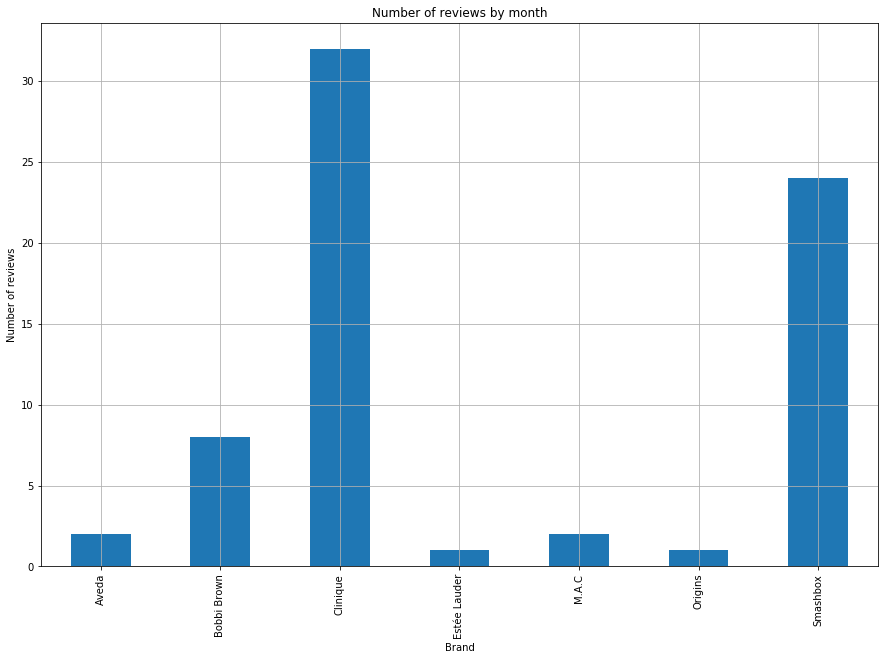

In [84]:
df.groupby('elc_brand')['nb_reviews'].sum().plot.bar(figsize=(15, 10))
plt.grid()
plt.xlabel('Brand')
plt.ylabel('Number of reviews')
plt.title('Number of reviews by month')

We see that the distribution is uneven. Pretty sure it's because different brands have different demand and therefore more reviews. Let's check that by adding the demand on another axis.

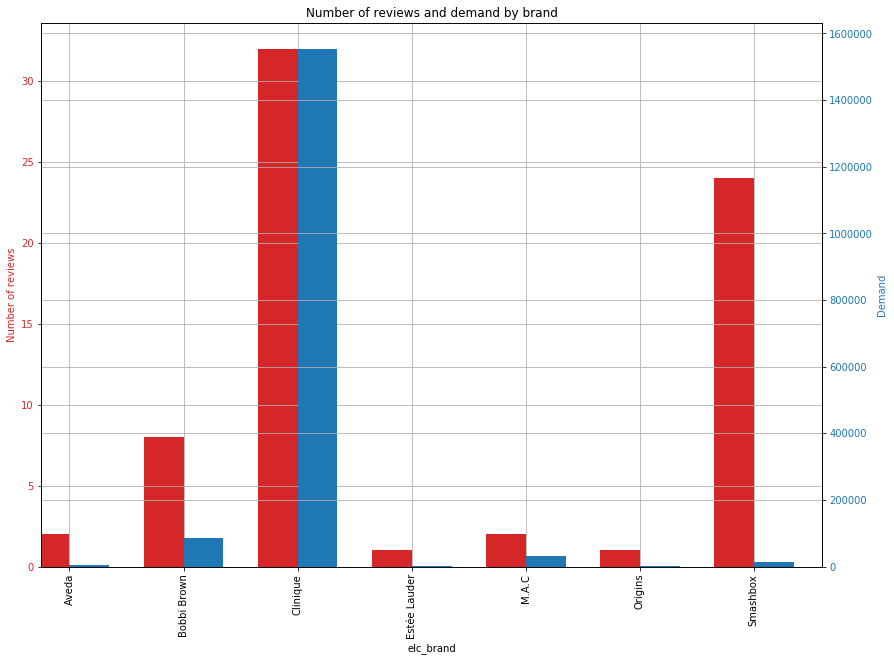

In [85]:
fig, ax1 = plt.subplots()

width = 0.35

color = 'tab:red'
ax1.set_xlabel('Brand')
ax1.set_ylabel('Number of reviews', color=color)
df.groupby('elc_brand')['nb_reviews'].sum().plot.bar(width=width, figsize=(14, 10), color=color, position=1)
# ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()


plt.xticks(ticks=range(len(df['elc_brand'].unique())), labels=df['elc_brand'].unique(), rotation='vertical')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Demand', color=color)  # we already handled the x-label with ax1
df.groupby('elc_brand')['demand'].sum().plot.bar(width=width, figsize=(14, 10), color=color, position=0)
ax2.tick_params(axis='y', labelcolor=color)
plt.grid()

plt.title('Number of reviews and demand by brand')
plt.show()

We can see some correlation with makes sense...

### Frequency of ratings by month across all brands

Text(0.5, 1.0, 'Frequency of ratings by month')

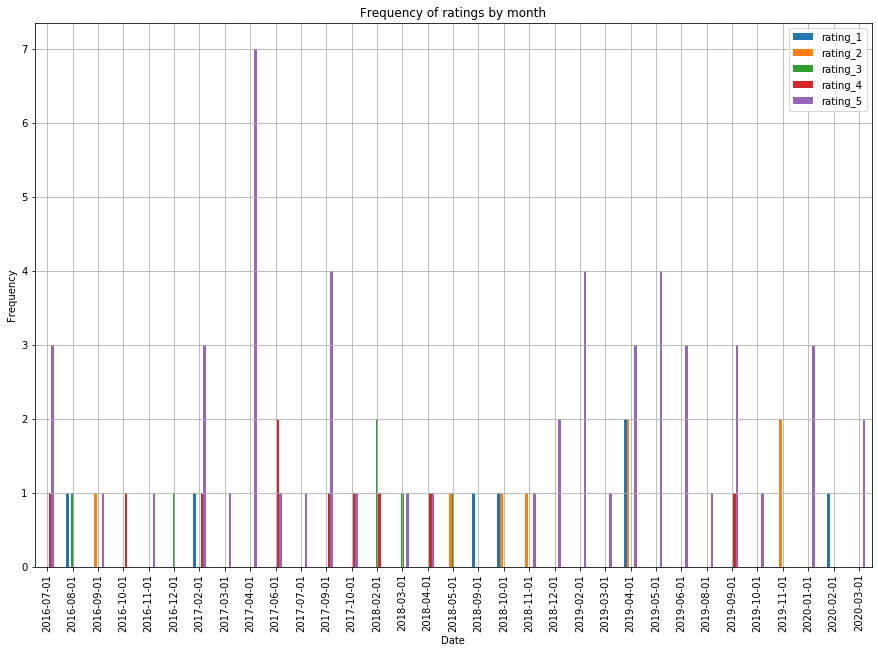

In [86]:
df[['date', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']].groupby('date').sum().plot.bar(figsize=(15, 10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of ratings by month')

We see that 5-star ratings are clearly prevailing.

### Average rating by brand (Average over the months of the average rating per month)
**!!!** As apposed to the average over all the reviews. Indeed, $avg(avg(x, month))\neq avg(x)$. 

Here is a list of all the available brands. 

In [87]:
# Available brands
df['elc_brand'].unique().tolist()

['Bobbi Brown',
 'Clinique',
 'M.A.C',
 'Smashbox',
 'Aveda',
 'Estée Lauder',
 'Origins']

Add the brands for which you'd like to see the average rating over time to the *selected_brands* list in the next cell.

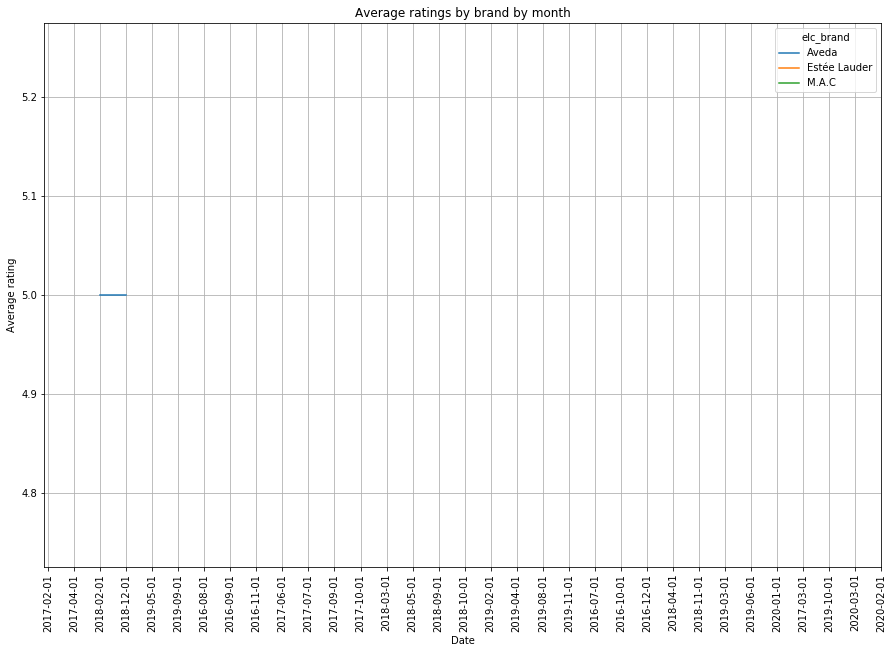

In [88]:
selected_brands = ['Aveda', 'M.A.C', 'Estée Lauder']
df[df['elc_brand'].isin(selected_brands)][['date', 'elc_brand', 'rating']].groupby(['date', 'elc_brand']).mean().unstack().droplevel(level=0,axis=1).plot.line(figsize=(15, 10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Average rating')
plt.title('Average ratings by brand by month')
plt.xticks(ticks=range(len(df['date'].unique())), labels=df['date'].unique(), rotation='vertical')
plt.show()

I noticed here that some brands did not get any ratings for some months. Maybe this shows that Rating and Reviews data that is scrapped is not of a very good quality **OR** perhaps there was 0 reviews for that brand ...

### Frequency of sentiments by month

Text(0.5, 1.0, 'Frequency of sentiments by month')

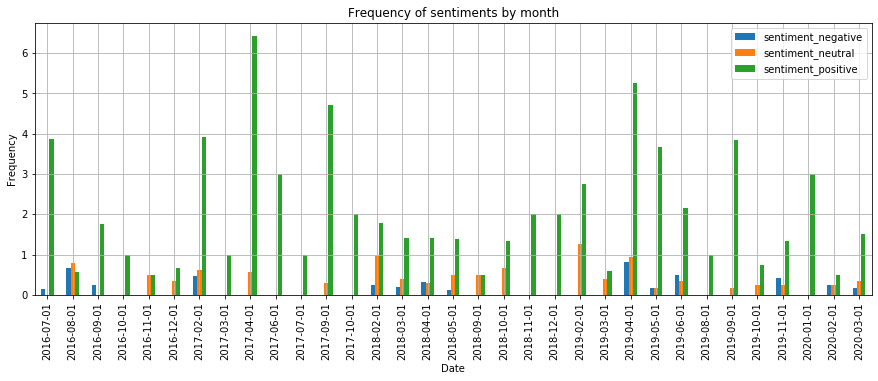

In [89]:
df[['date', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']].groupby('date').sum().plot.bar(figsize=(15, 5))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of sentiments by month')

Again we see here that positive sentiments prevail.

### Average sentiment by brand  (Average over the months of the average rating per month)
**!!!** As apposed to the average over all the reviews. Indeed, $avg(avg(x, month))\neq avg(x)$. 

Add the brands for which you'd like to see the average sentiment over time to the *selected_brands* list in the next cell.

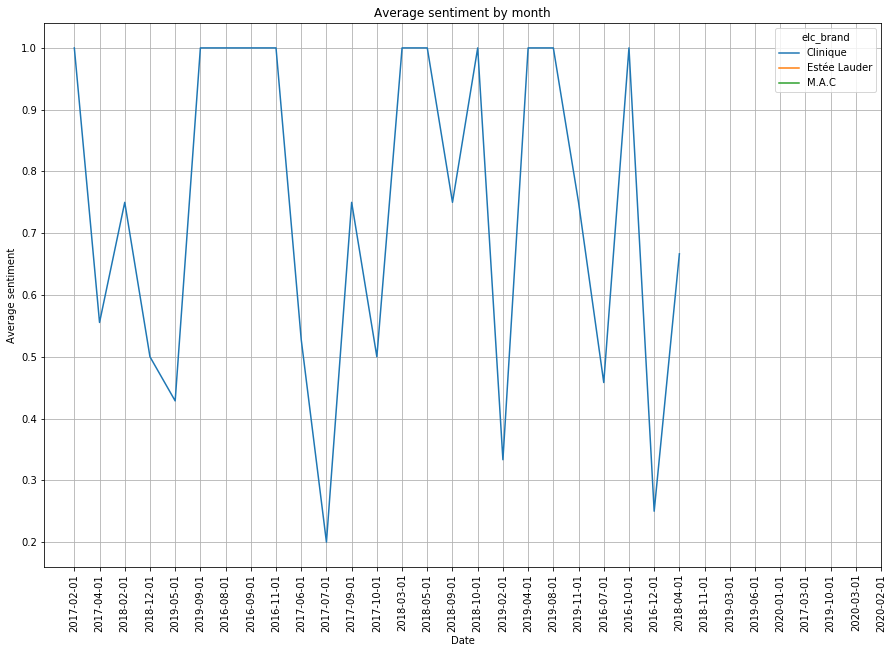

In [90]:
selected_brands = ['Clinique', 'M.A.C', 'Estée Lauder']
df[df['elc_brand'].isin(selected_brands)][['date', 'elc_brand', 'sentiment']].groupby(['date', 'elc_brand']).mean().unstack().droplevel(level=0,axis=1).plot.line(figsize=(15, 10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Average sentiment')
plt.title('Average sentiment by month')
plt.xticks(ticks=range(len(df['date'].unique())), labels=df['date'].unique(), rotation='vertical')
plt.show()

### Ratings (avg by brand) and Demand by month

Finally, we plot the average rating by brand and the increase in demand month over month in %.

=============================================== Bobbi Brown ===============================================


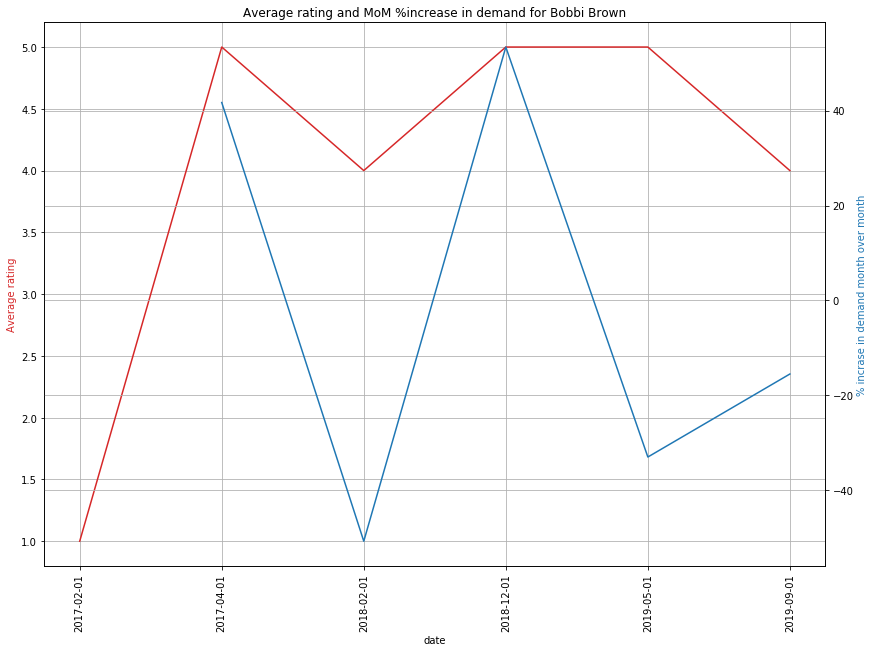

=============================================== Clinique ===============================================


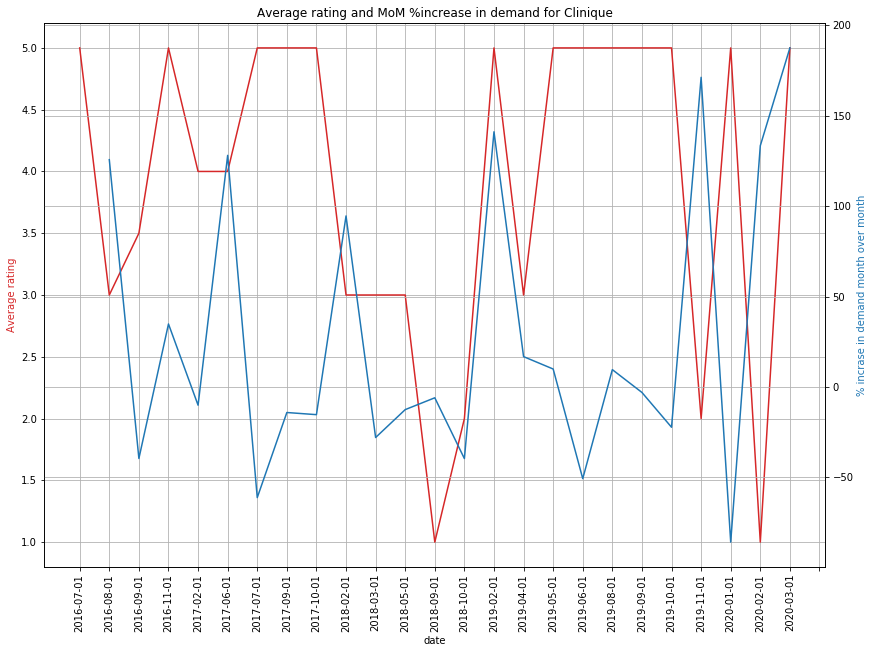

=============================================== M.A.C ===============================================


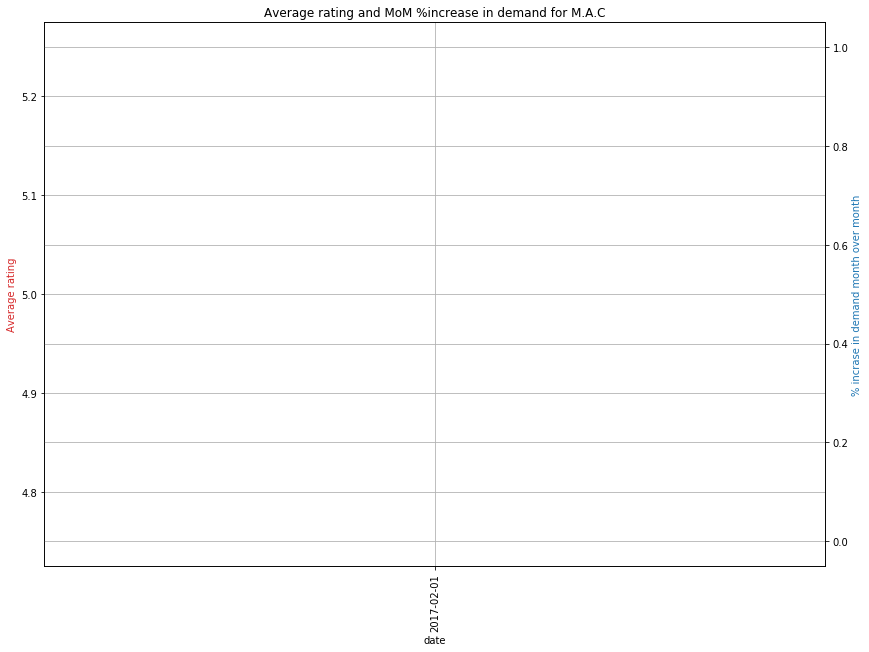

=============================================== Smashbox ===============================================


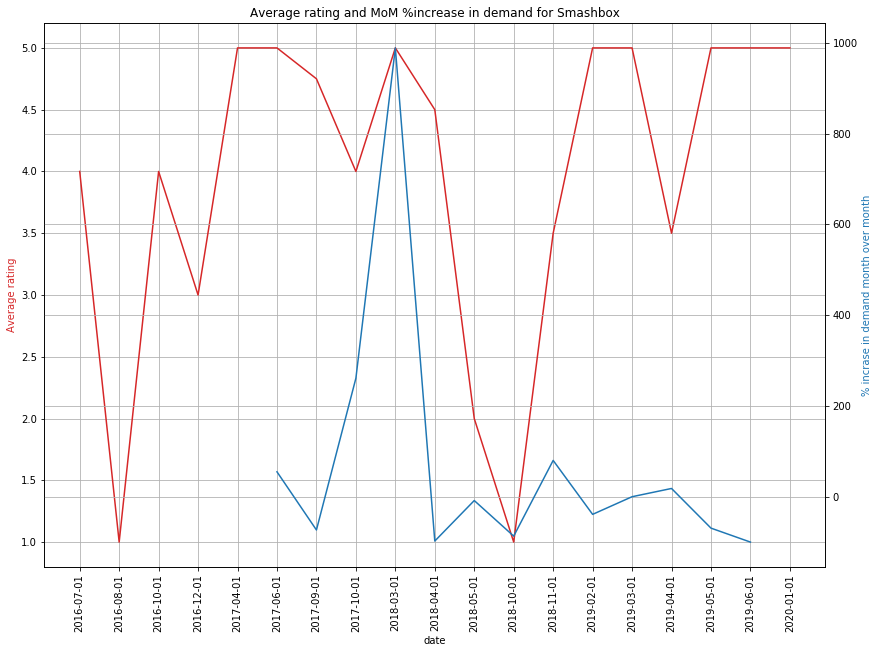

=============================================== Aveda ===============================================


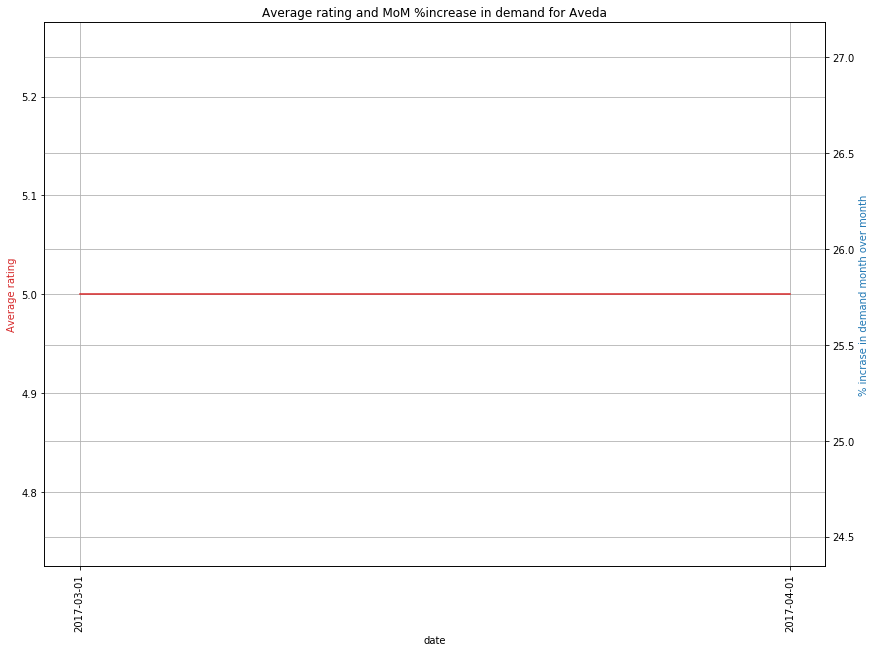

=============================================== Estée Lauder ===============================================


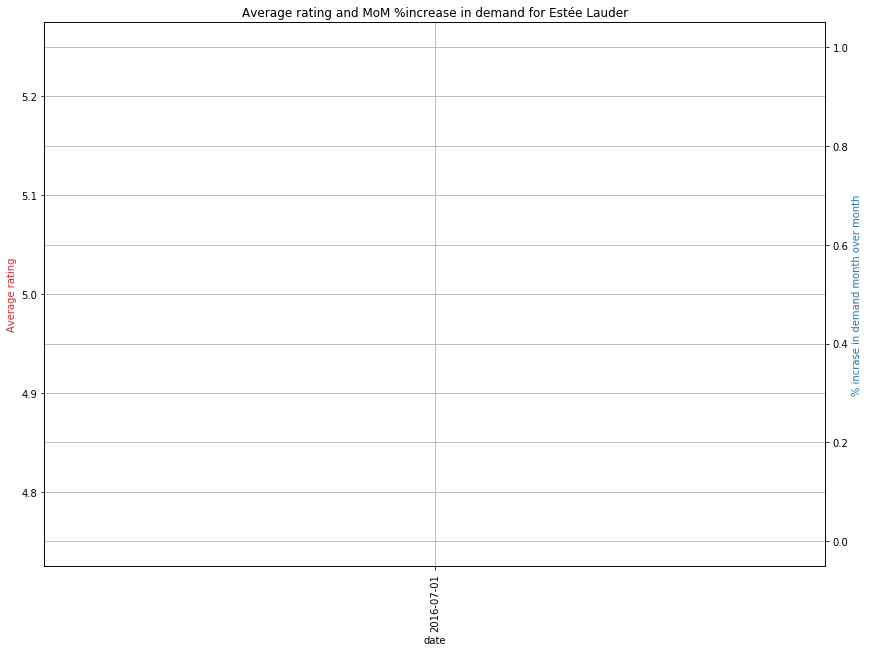

=============================================== Origins ===============================================


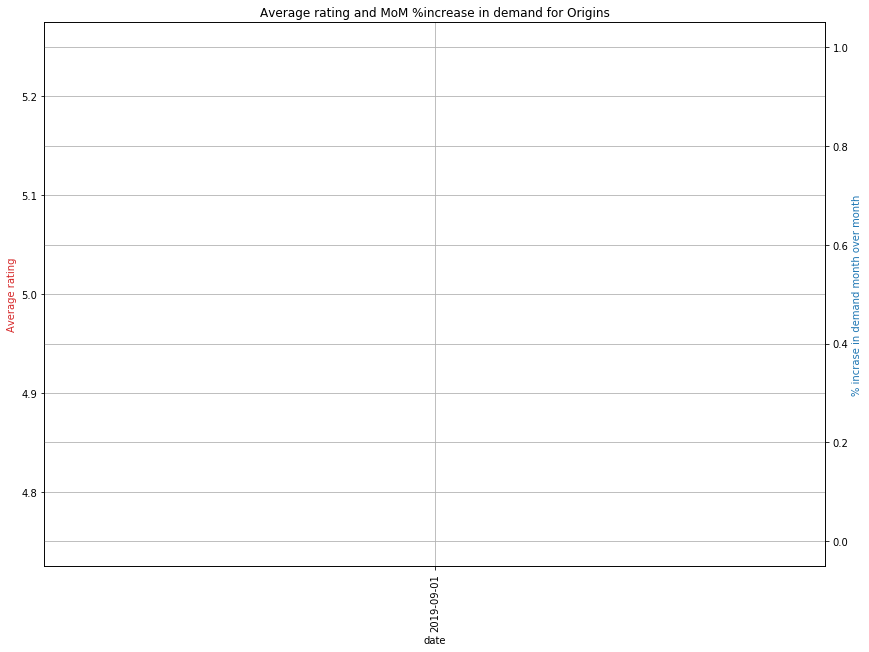

In [91]:
for brand in df['elc_brand'].unique():
    print('=============================================== {} ==============================================='.format(brand))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Brand')
    ax1.set_ylabel('Average rating', color=color)
    df[df['elc_brand']==brand].groupby('date')['rating'].mean().plot.line(figsize=(14, 10), color=color)
    plt.grid()

    plt.xticks(ticks=range(len(df['date'].unique())), labels=df['date'].unique(), rotation='vertical')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('% incrase in demand month over month', color=color)  # we already handled the x-label with ax1
    (df[df['elc_brand']==brand].groupby('date')['demand'].sum().diff().div(df[df['elc_brand']==brand].groupby('date')['demand'].sum().shift())*100).plot.line(figsize=(14, 10), color=color)
    plt.grid()
    
    plt.title('Average rating and MoM %increase in demand for {}'.format(brand))
    plt.show()

I can't see any solid clear trends in these graphs... I also noticed that for some brands we have a lot of missing demand data (missing or non-existing)...

### Demand vs Rating 

=========================================== Bobbi Brown ===========================================


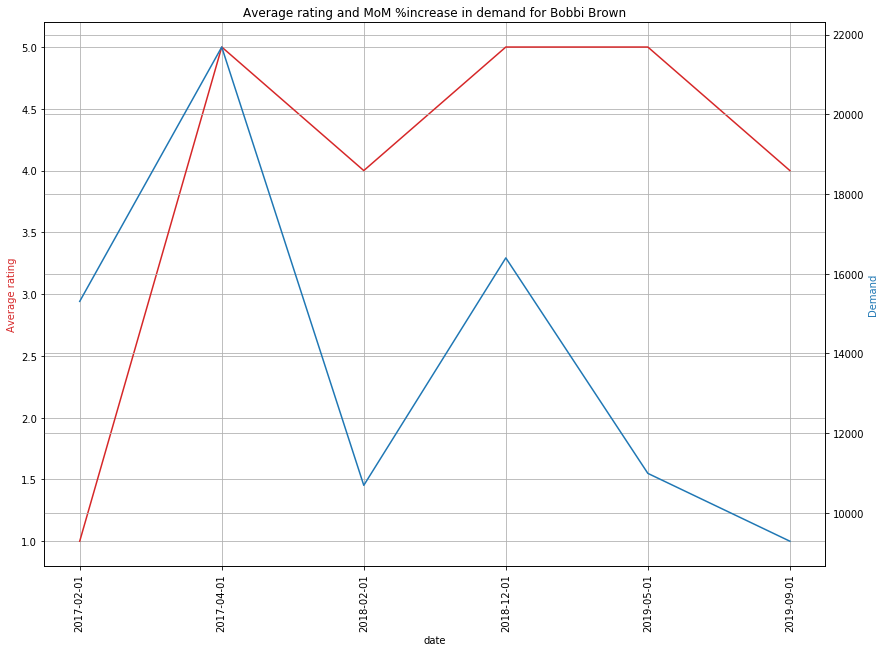

=========================================== Clinique ===========================================


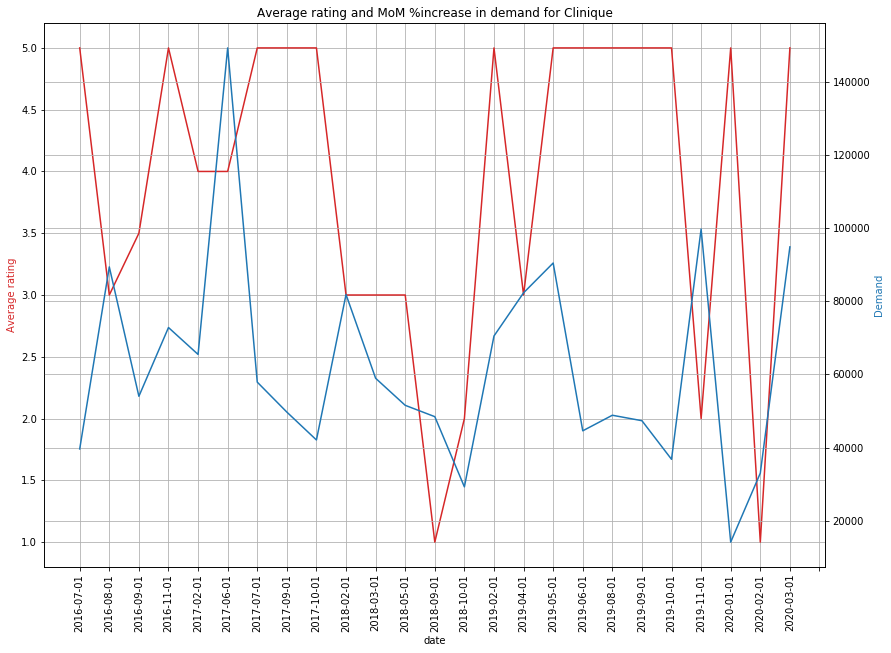

=========================================== M.A.C ===========================================


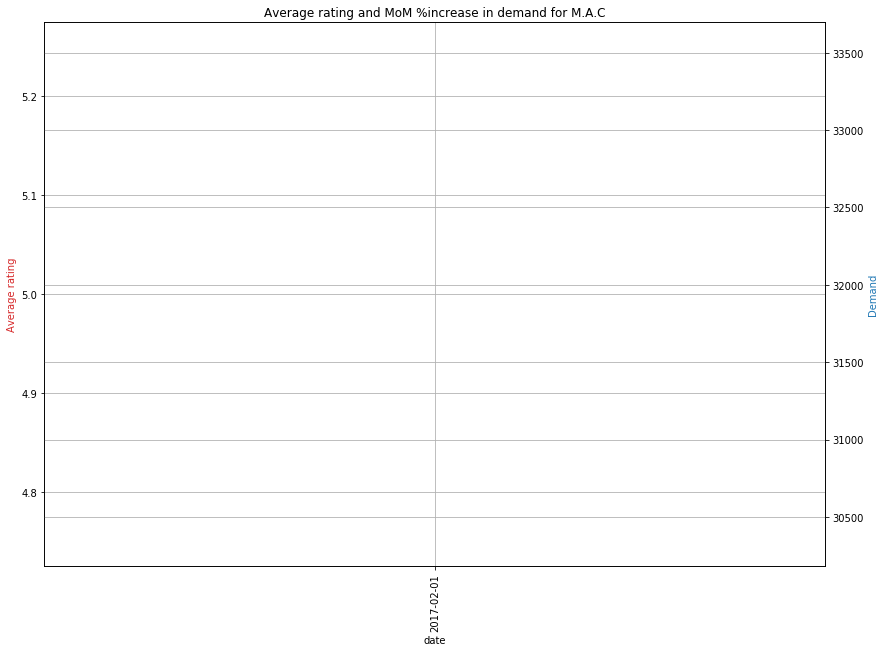

=========================================== Smashbox ===========================================


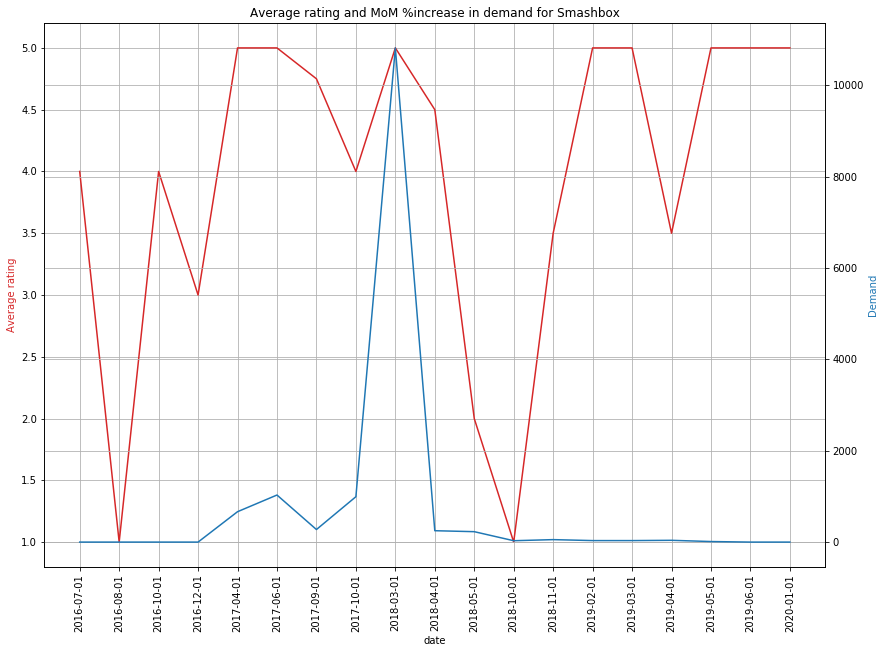

=========================================== Aveda ===========================================


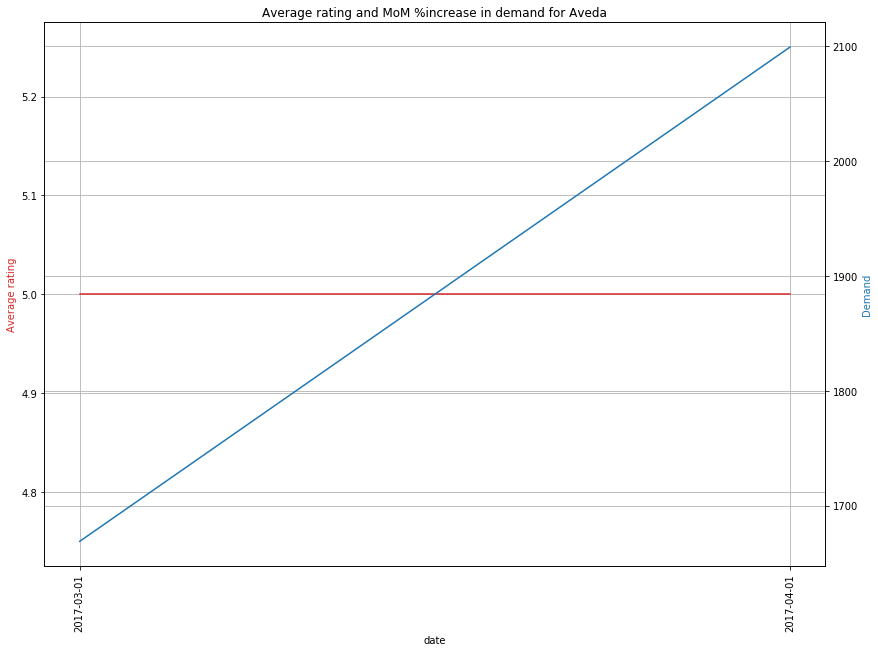

=========================================== Estée Lauder ===========================================


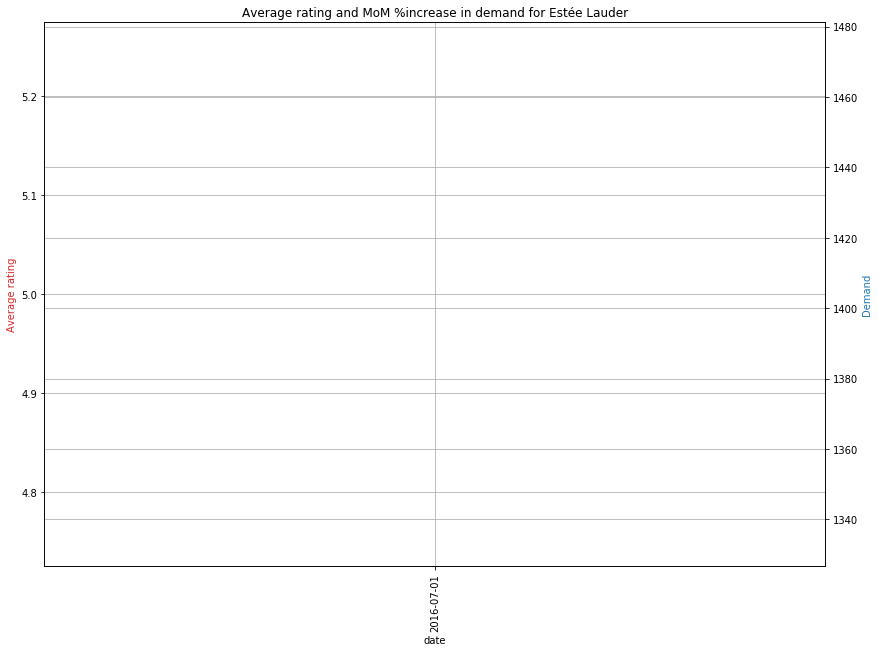

=========================================== Origins ===========================================


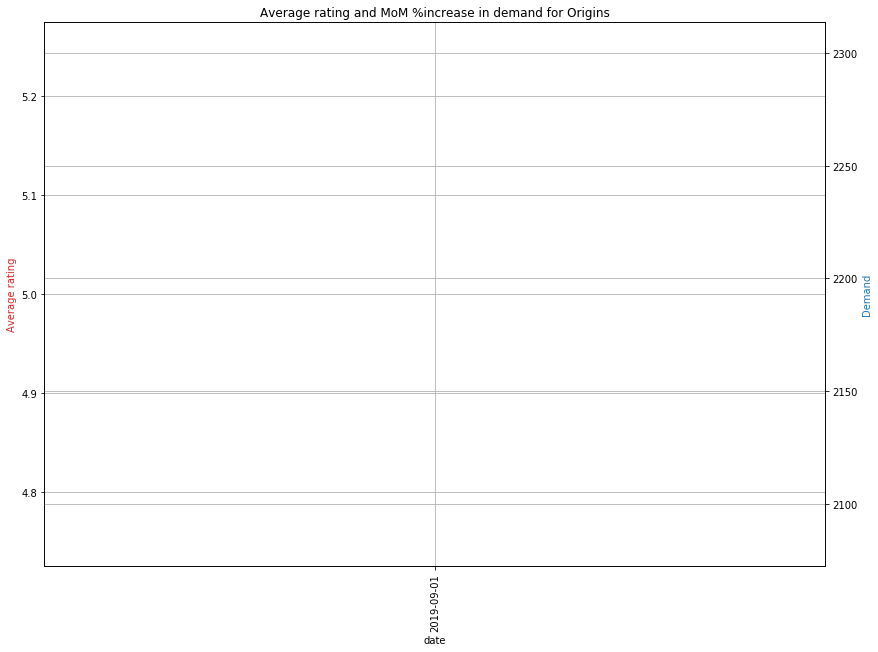

In [92]:
for brand in df['elc_brand'].unique(): 
    print('=========================================== {} ==========================================='.format(brand))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Brand')
    ax1.set_ylabel('Average rating', color=color)
    df[df['elc_brand']==brand].groupby('date')['rating'].mean().plot.line(figsize=(14, 10), color=color)
    plt.grid()

    plt.xticks(ticks=range(len(df['date'].unique())), labels=df['date'].unique(), rotation='vertical')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Demand', color=color)  # we already handled the x-label with ax1
    df[df['elc_brand']==brand].groupby('date')['demand'].sum().plot.line(figsize=(14, 10), color=color)
    plt.grid()
    
    plt.title('Average rating and MoM %increase in demand for {}'.format(brand))
    plt.show()

## Model 0 : Everything in the soup

In [93]:
lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

NameError: name 'X' is not defined

We start with a model that uses both Ratings and Sentiments. The data we have ranges from 

In [ ]:
train = df[df['date'] <= '2018-12-01']
X_train = train.iloc[:, 5:-1]
X_train = sm.add_constant(X_train)
y_train = train.iloc[:, -1]
X_train

In [ ]:
train = df[df['date'] <= '2018-12-01']
X_train = train.iloc[:, 4:-1]
X_train = sm.add_constant(X_train)
y_train = train.iloc[:, -1]

test = df[df['date'] > '2018-12-01']
X_test = test.iloc[:, 4:-1]
X_test = sm.add_constant(X_test)
y_test = test.iloc[:, -1]

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()

print(olsres.summary())

The coefficients for the ratings are all negative. Those of the sentiment are all positive and we have a small warning about some very small eigenvalue. That is because there is a lot of correlation between the features. Let's look at the correlation between our variables.

In [ ]:
train.iloc[:, 4:-1].corr()

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train.iloc[:, 4:-1].corr(), fignum=f.number, cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(range(train.iloc[:, 4:-1].shape[1]), train.iloc[:, 4:-1].columns, fontsize=14, rotation=45)
plt.yticks(range(train.iloc[:, 4:-1].shape[1]), train.iloc[:, 4:-1].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

We see a correlation between the ratings and the sentiments (rating_5 with sentiment_positive and vice-versa). But the sentiments are also correlated between themselves which is probably *no bueno*. This is due to the fact that we are using onehot encodings with counts. If the number of reviews increases, rating_1 to rating_5 are likely to increase too...

Let's quickly try some feature selection.

## Model 1 : demand = f(nb_reviews, rating, sentiment)

In [ ]:
train = df[df['date'] <= '2018-12-01']
X_train = train.iloc[:, 4:7]
X_train = sm.add_constant(X_train)
y_train = train.iloc[:, -1]

test = df[df['date'] > '2018-12-01']
X_test = test.iloc[:, 4:-4]
X_test = sm.add_constant(X_test)
y_test = test.iloc[:, -1]

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()

print(olsres.summary())


Import Data

In [ ]:
df = pd.read_csv("../data/Global Demand Data Wrangling/output/monthly_product_demand.csv")
demand['demand'] = pd.to_numeric(demand['demand'].str.replace(',', ''), errors='coerce')

Filter out demand forecast data

In [ ]:
demand["datetime"] = pd.to_datetime(demand["month_date"])
CUTOFF = datetime.datetime(2020, 2, 1)
demand = demand.loc[demand["datetime"]<= CUTOFF]

In [ ]:
demand

Create demand lags

In [ ]:
demand["demand_lag_1"] = demand.groupby("ItemID 4")["demand"].shift()
demand["demand_lag_2"] = demand.groupby("ItemID 4")["demand"].shift(2)
demand["demand_lag_3"] = demand.groupby("ItemID 4")["demand"].shift(3)
demand.dropna(inplace=True)